In [4]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rxr

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import mplcursors

In [2]:
%matplotlib inline

### Import data 

In [10]:
# import UCRB boundaries
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [15]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

In [3]:
# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')

# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt.nc')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})
hcdn_seasonal_ppt = hcdn_seasonal_ppt.where(~hcdn_seasonal_ppt.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)
hcdn_annual_ppt = hcdn_seasonal_ppt.groupby('year').sum()

# UCRB monthly precipitation
prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

# UCRB naturalized streamflow
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()

### Here is where we compute the PRISM normals for the HCDN basins

In [5]:
# # UCRB Normals 
# # Download PRISM normals 
# outpath = '../data/precipdata/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
# files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
# prism_list = []
# for file in files:
#        prism_list.append(rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry))
# prism_normals_ds = xr.concat(prism_list, dim='band')
# prism_normals_ds = prism_normals_ds.rename({'band':'month'})

# prism_normals_ds = prism_normals_ds.assign_coords({
#         'month': [1,2,3,4,5,6,7,8,9,10,11,12]})

# # for each hcdn_basin_boundary, get the prism normal ds precipitation
# hcdn_normal_precip = {}
# for site_no in hcdn_basins.index:
#     tmp = hcdn_basins[hcdn_basins.index==site_no]
#     tmp_ds = prism_normals_ds.rio.clip(tmp.geometry, all_touched=True)
#     # filter tmp_ds to all values equal to or above 0
#     tmp_ds = tmp_ds.where(tmp_ds>=0)
#     hcdn_normal_precip[site_no] = tmp_ds.mean(dim=['x','y'])
# convert hcdn_noraml_precip to an array
# hcdn_normals_ds = xr.Dataset(hcdn_normal_precip).to_array()
# # rename the variable to site_no
# hcdn_normals_ds = hcdn_normals_ds.rename({'variable': 'site_no'})
# # name the dataarray ppt
# hcdn_normals_ds = hcdn_normals_ds.rename('ppt')
# # save as a file
# hcdn_normals_ds.to_netcdf('../data/precipdata/hcdn_normals.nc')

In [5]:
# iterate to find the first year at each site_no with a valid q_mm value in hcdn_annual_q
first_year = []
for site in hcdn_annual_q.site_no.values:
    first_year.append(hcdn_annual_q.sel(site_no=site).q_mm.to_pandas().dropna().index[0])

In [ ]:
# open the hcdn_normals_ds 
hcdn_normals_ds = xr.open_dataset('../data/precipdata/hcdn_normals.nc')


<xarray.Dataset>
Dimensions:      (month: 12, site_no: 26)
Coordinates:
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 ...
  * site_no      (site_no) object '09034900' '09035900' ... '09361500'
Data variables:
    ppt          (site_no, month) float32 ...

### Hypothesis testing for change in the flow center of mass between pre- and post-2000 periods

Calculate the daily center of mass for each site for each year

In [34]:
center_of_mass_date = {}
for year in hcdn_daily_q.WY.to_series().unique():
    example = hcdn_daily_q.where(hcdn_daily_q.WY==year,drop=True)['q_mm_day'].cumsum(dim='date')
    com_value = example.max(dim='date')/2
    center_of_mass_date[year] = abs(example - com_value).idxmin(dim='date').dt.dayofyear.to_dataframe()
    
center_of_mass_date_da = xr.Dataset(center_of_mass_date).to_array().squeeze()
center_of_mass_date_da = center_of_mass_date_da.where((center_of_mass_date_da>52) & (center_of_mass_date_da<238))
center_of_mass_date_da = center_of_mass_date_da.rename({'variable':'year'})
center_of_mass_date_da.name = 'flow_com'

In [35]:
# Zero is the mid elevation basins, 1 is the low elevation basins, and 2 are the high elevation basins
basin_elevation_groups = pd.read_csv('../data/geodata/basin_elevation_groups.csv', index_col=1).drop(columns='Unnamed: 0')
basin_elevation_groups.index =  ['0'+str(site) for site in basin_elevation_groups.index.values]
basin_group_da = basin_elevation_groups.to_xarray().rename({'index':'site_no'})

# Merge this data array onto the datasets for use
hcdn_daily_q = hcdn_daily_q.merge(basin_group_da)
hcdn_annual_q = hcdn_annual_q.merge(basin_group_da)
hcdn_annual_q = hcdn_annual_q.merge(center_of_mass_date_da)
hcdn_seasonal_ppt = hcdn_seasonal_ppt.merge(basin_group_da)
hcdn_annual_ppt = hcdn_seasonal_ppt.merge(basin_group_da)
hcdn_normals_ds = hcdn_normals_ds.merge(basin_group_da)

Separate into low-, mid- and high- elevation sites

In [8]:
high_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 2, drop=True)
mid_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 0, drop=True)
low_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 1, drop=True)

high_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 2, drop=True)
mid_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 0, drop=True)
low_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 1, drop=True)

high_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 2, drop=True)
mid_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 0, drop=True)
low_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 1, drop=True)

high_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 2, drop=True)
mid_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 0, drop=True)
low_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 1, drop=True)

In [9]:
conf = 0.05
test_start_year = 1964

1) High Elevation Basins

In [10]:
high_com_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [11]:
high_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.892358,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09065500,0.872616,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN
09066200,0.496821,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN
09081600,0.778521,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN
09352900,0.226424,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN


2) Mid Elevation Basins

In [12]:
mid_com_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [13]:
mid_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.668986,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN
09047700,0.002336,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.012,Null Hypothesis Rejected
09066000,0.584393,Probably Gaussian,0.055,Null Hypothesis Accepted,NaN,NaN
09066300,0.91807,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09107000,0.034089,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.115,Null Hypothesis Accepted
09110000,0.10967,Probably Gaussian,0.694,Null Hypothesis Accepted,NaN,NaN
09112500,0.824163,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN
09115500,0.910124,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN
09124500,0.342914,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN
09146200,0.369699,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN


3) Low Elevation Basins

In [14]:
low_com_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'




In [15]:
low_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.000425,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.345,Null Hypothesis Accepted
09132500,0.817359,Probably Gaussian,0.327,Null Hypothesis Accepted,NaN,NaN
09147500,0.120365,Probably Gaussian,0.822,Null Hypothesis Accepted,NaN,NaN
09183500,0.224348,Probably Gaussian,0.139,Null Hypothesis Accepted,NaN,NaN
09210500,0.00002,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.058,Null Hypothesis Accepted
09223000,0.001723,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.047,Null Hypothesis Rejected
09239500,0.340681,Probably Gaussian,0.096,Null Hypothesis Accepted,NaN,NaN
09304500,0.000008,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.002,Null Hypothesis Rejected
09312600,0.243174,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN


Flow Center of Mass Change Plots

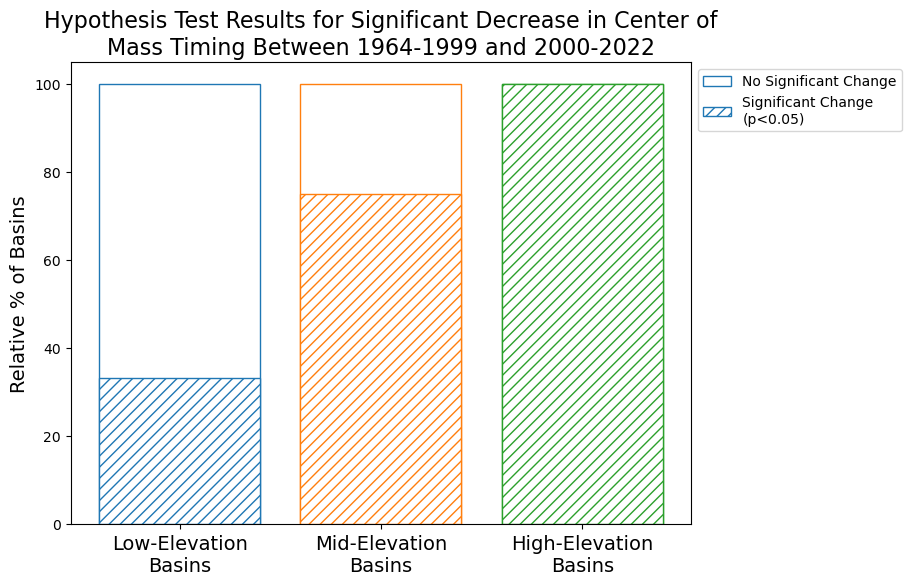

In [16]:

# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

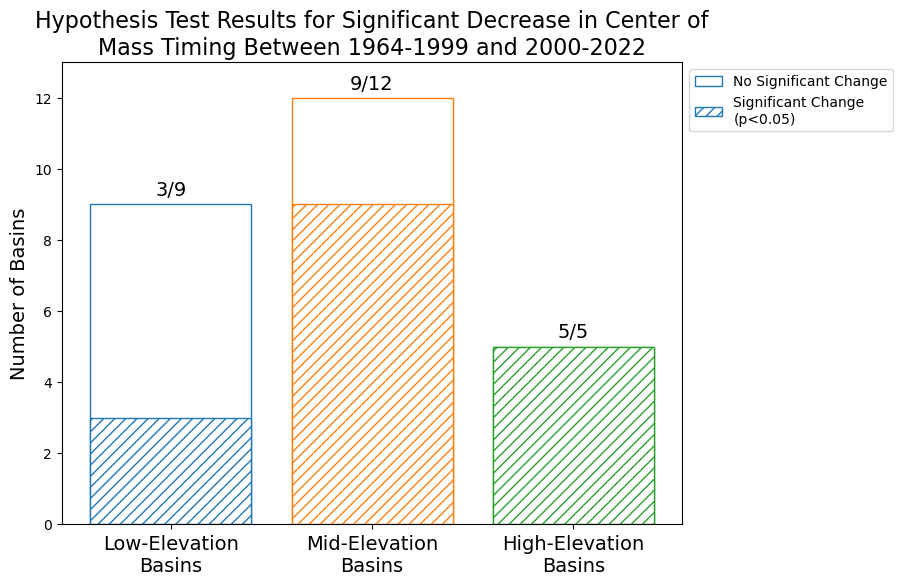

In [17]:
# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[9, 12, 5], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[(low_rejected), (mid_rejected), (high_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in annual mean flow between pre- and post-2000 periods

1) High Elevation Basins

In [18]:
high_meanq_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
       
    else:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
     # calculate the percent change between the two periods
    high_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    high_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [19]:
high_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference [mm]
09034900,0.257247,Probably Gaussian,0.074,Null Hypothesis Accepted,NaN,NaN,-8.9,-61.6
09065500,0.154987,Probably Gaussian,0.067,Null Hypothesis Accepted,NaN,NaN,-10.5,-75.9
09066200,0.349053,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN,-13.0,-87.9
09081600,0.268566,Probably Gaussian,0.043,Null Hypothesis Rejected,NaN,NaN,-12.9,-81.5
09352900,0.182733,Probably Gaussian,0.018,Null Hypothesis Rejected,NaN,NaN,-15.0,-107.6


2) Mid Elevation Basins

In [20]:
mid_meanq_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    mid_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    mid_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round((single_site_post.mean()-single_site_pre.mean()),1)

In [21]:
mid_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference [mm]
09035900,0.092024,Probably Gaussian,0.423,Null Hypothesis Accepted,NaN,NaN,-1.4,-5.8
09047700,0.023451,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.324,Null Hypothesis Accepted,-9.3,-22.8
09066000,0.278424,Probably Gaussian,0.148,Null Hypothesis Accepted,NaN,NaN,-9.0,-43.2
09066300,0.055656,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN,-16.6,-56.2
09107000,0.08214,Probably Gaussian,0.081,Null Hypothesis Accepted,NaN,NaN,-15.0,-47.1
09110000,0.221857,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN,-18.7,-45.1
09112500,0.980475,Probably Gaussian,0.027,Null Hypothesis Rejected,NaN,NaN,-16.3,-65.8
09115500,0.978662,Probably Gaussian,0.125,Null Hypothesis Accepted,NaN,NaN,-13.1,-19.9
09124500,0.748093,Probably Gaussian,0.092,Null Hypothesis Accepted,NaN,NaN,-9.9,-23.6
09146200,0.956225,Probably Gaussian,0.045,Null Hypothesis Rejected,NaN,NaN,-11.1,-44.0


3) Low Elevation Basins

In [22]:
low_meanq_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    low_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    low_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round((single_site_post.mean()-single_site_pre.mean()),1)

In [23]:
low_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference [mm]
09119000,0.003685,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.022,Null Hypothesis Rejected,-22.2,-13.1
09132500,0.139089,Probably Gaussian,0.008,Null Hypothesis Rejected,NaN,NaN,-22.3,-72.2
09147500,0.183437,Probably Gaussian,0.019,Null Hypothesis Rejected,NaN,NaN,-18.3,-37.6
09183500,0.551137,Probably Gaussian,0.009,Null Hypothesis Rejected,NaN,NaN,-28.6,-45.7
09210500,0.242508,Probably Gaussian,0.137,Null Hypothesis Accepted,NaN,NaN,-12.6,-21.5
09223000,0.836744,Probably Gaussian,0.017,Null Hypothesis Rejected,NaN,NaN,-23.1,-65.8
09239500,0.785031,Probably Gaussian,0.118,Null Hypothesis Accepted,NaN,NaN,-10.3,-29.3
09304500,0.791317,Probably Gaussian,0.026,Null Hypothesis Rejected,NaN,NaN,-14.5,-42.1
09312600,0.340267,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN,-39.1,-51.7


4. Upper Colorado River Basin

In [24]:
ucrb_meanq_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])

single_site_pre = ucrb_naturalized_streamflow['q_mm_day'].loc[test_start_year:1999]
single_site_post = ucrb_naturalized_streamflow['q_mm_day'].loc[2000:2022]
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_meanq_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_meanq_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [25]:
ucrb_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
UCRB,0.840977,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN


Annual Mean Flow Change Plots

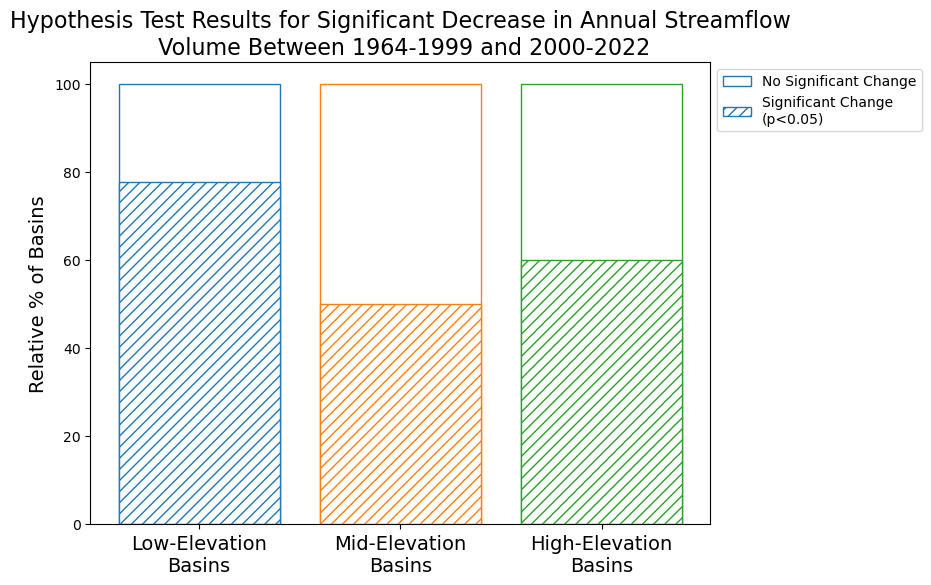

In [26]:

# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

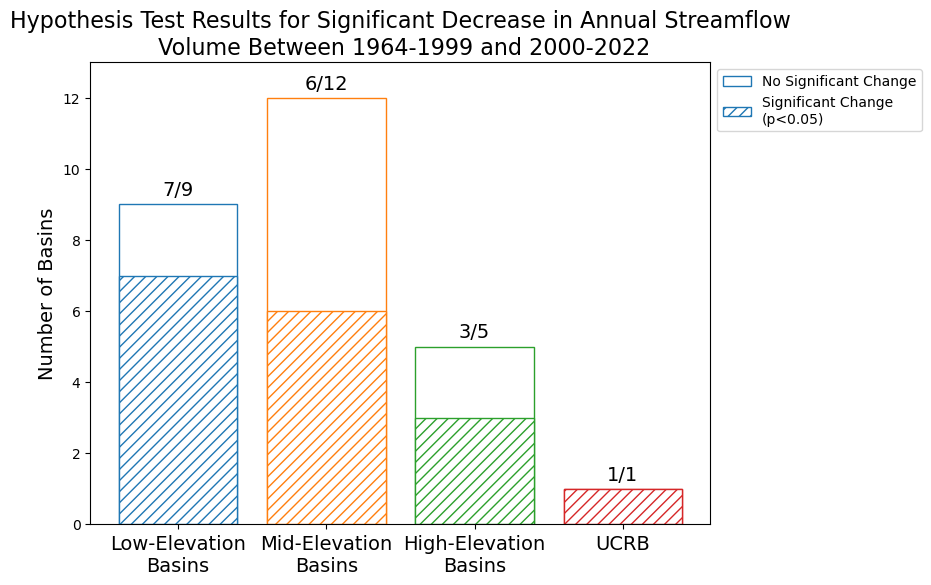

In [27]:
# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
ucrb_rejected = len(ucrb_meanq_ttest_results[(ucrb_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_meanq_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in the distribution of seasonal precipitation in pre- and post-2000 periods

1) High Elevation Basins

Text(0.5, 1.0, 'Summer')

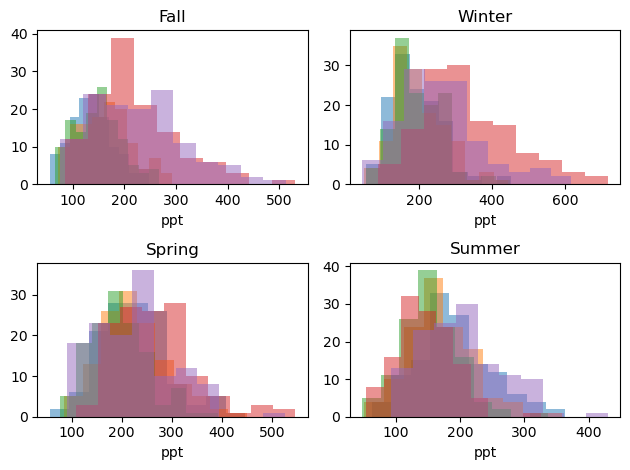

In [28]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in high_elevation_seasonal_ppt.site_no:
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==9,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==12,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==3,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==6,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [29]:
high_fallp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==9, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==9, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [30]:
high_winterp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [31]:
high_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.015406,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.643,Null Hypothesis Accepted
09065500,0.021293,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.487,Null Hypothesis Accepted
09066200,0.03624,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.551,Null Hypothesis Accepted
09081600,0.190298,Probably Gaussian,0.17,Null Hypothesis Accepted,NaN,NaN
09352900,0.104066,Probably Gaussian,0.57,Null Hypothesis Accepted,NaN,NaN


In [32]:
high_springp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    high_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    high_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [33]:
high_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.062957,Probably Gaussian,0.365,Null Hypothesis Accepted,NaN,NaN,-2.2,-5.3
09065500,0.164491,Probably Gaussian,0.469,Null Hypothesis Accepted,NaN,NaN,-0.6,-1.3
09066200,0.098773,Probably Gaussian,0.783,Null Hypothesis Accepted,NaN,NaN,5.8,11.4
09081600,0.012826,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.038,Null Hypothesis Rejected,-12.8,-35.9
09352900,0.429131,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN,-22.0,-51.9


In [34]:
high_summerp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    ])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        high_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    

In [35]:
high_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.474125,Probably Gaussian,0.752,Null Hypothesis Accepted,NaN,NaN
09065500,0.769866,Probably Gaussian,0.712,Null Hypothesis Accepted,NaN,NaN
09066200,0.38685,Probably Gaussian,0.736,Null Hypothesis Accepted,NaN,NaN
09081600,0.190672,Probably Gaussian,0.718,Null Hypothesis Accepted,NaN,NaN
09352900,0.997132,Probably Gaussian,0.998,Null Hypothesis Rejected,NaN,NaN


2) Mid Elevation Basins

Text(0.5, 1.0, 'Summer')

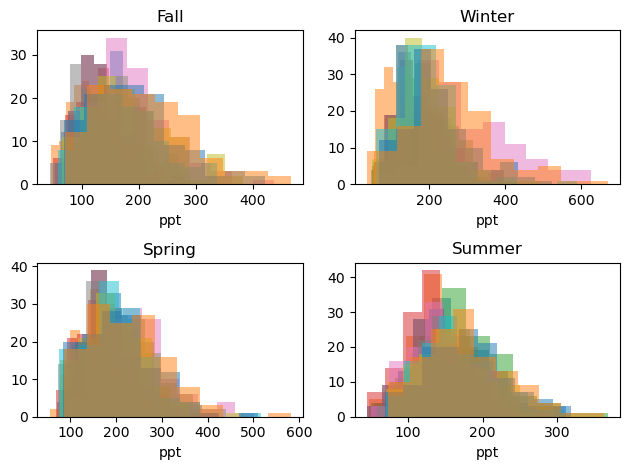

In [36]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in mid_elevation_seasonal_ppt.site_no:
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==9,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==12,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==3,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==6,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [37]:
mid_fallp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==9, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==9, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [38]:
mid_fallp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.912988,Probably Gaussian,0.507,Null Hypothesis Accepted,NaN,NaN
09047700,0.543447,Probably Gaussian,0.371,Null Hypothesis Accepted,NaN,NaN
09066000,0.378792,Probably Gaussian,0.38,Null Hypothesis Accepted,NaN,NaN
09066300,0.721379,Probably Gaussian,0.711,Null Hypothesis Accepted,NaN,NaN
09107000,0.156485,Probably Gaussian,0.236,Null Hypothesis Accepted,NaN,NaN
09110000,0.156485,Probably Gaussian,0.236,Null Hypothesis Accepted,NaN,NaN
09112500,0.73464,Probably Gaussian,0.062,Null Hypothesis Accepted,NaN,NaN
09115500,0.275932,Probably Gaussian,0.174,Null Hypothesis Accepted,NaN,NaN
09124500,0.235709,Probably Gaussian,0.216,Null Hypothesis Accepted,NaN,NaN
09146200,0.093685,Probably Gaussian,0.248,Null Hypothesis Accepted,NaN,NaN


In [39]:
mid_winterp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [40]:
mid_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.040913,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.732,Null Hypothesis Accepted
09047700,0.056199,Probably Gaussian,0.923,Null Hypothesis Accepted,NaN,NaN
09066000,0.032856,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.544,Null Hypothesis Accepted
09066300,0.05573,Probably Gaussian,0.818,Null Hypothesis Accepted,NaN,NaN
09107000,0.108213,Probably Gaussian,0.472,Null Hypothesis Accepted,NaN,NaN
09110000,0.108213,Probably Gaussian,0.472,Null Hypothesis Accepted,NaN,NaN
09112500,0.232483,Probably Gaussian,0.162,Null Hypothesis Accepted,NaN,NaN
09115500,0.240446,Probably Gaussian,0.405,Null Hypothesis Accepted,NaN,NaN
09124500,0.184203,Probably Gaussian,0.608,Null Hypothesis Accepted,NaN,NaN
09146200,0.090934,Probably Gaussian,0.663,Null Hypothesis Accepted,NaN,NaN


In [41]:
mid_springp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)]
    single_site_post = mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    mid_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    mid_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [42]:
mid_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09035900,0.236696,Probably Gaussian,0.469,Null Hypothesis Accepted,NaN,NaN,-0.5,-1.2
09047700,0.250574,Probably Gaussian,0.859,Null Hypothesis Accepted,NaN,NaN,8.3,12.1
09066000,0.230215,Probably Gaussian,0.37,Null Hypothesis Accepted,NaN,NaN,-2.4,-5.8
09066300,0.033706,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.853,Null Hypothesis Accepted,7.6,11.5
09107000,0.000812,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.034,Null Hypothesis Rejected,-13.9,-27.5
09110000,0.000812,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.034,Null Hypothesis Rejected,-13.9,-27.5
09112500,0.008365,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.016,Null Hypothesis Rejected,-16.1,-41.4
09115500,0.012757,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.056,Null Hypothesis Accepted,-14.0,-24.6
09124500,0.302725,Probably Gaussian,0.023,Null Hypothesis Rejected,NaN,NaN,-15.6,-31.2
09146200,0.280306,Probably Gaussian,0.039,Null Hypothesis Rejected,NaN,NaN,-13.9,-28.2


In [43]:
mid_summerp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        mid_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [44]:
mid_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.807208,Probably Gaussian,0.831,Null Hypothesis Accepted,NaN,NaN
09047700,0.807315,Probably Gaussian,0.614,Null Hypothesis Accepted,NaN,NaN
09066000,0.465271,Probably Gaussian,0.62,Null Hypothesis Accepted,NaN,NaN
09066300,0.345525,Probably Gaussian,0.49,Null Hypothesis Accepted,NaN,NaN
09107000,0.298156,Probably Gaussian,0.779,Null Hypothesis Accepted,NaN,NaN
09110000,0.298156,Probably Gaussian,0.779,Null Hypothesis Accepted,NaN,NaN
09112500,0.211961,Probably Gaussian,0.822,Null Hypothesis Accepted,NaN,NaN
09115500,0.138325,Probably Gaussian,0.969,Null Hypothesis Rejected,NaN,NaN
09124500,0.593709,Probably Gaussian,0.961,Null Hypothesis Rejected,NaN,NaN
09146200,0.551606,Probably Gaussian,0.959,Null Hypothesis Rejected,NaN,NaN


3) Low Elevation Basins

Text(0.5, 1.0, 'Summer')

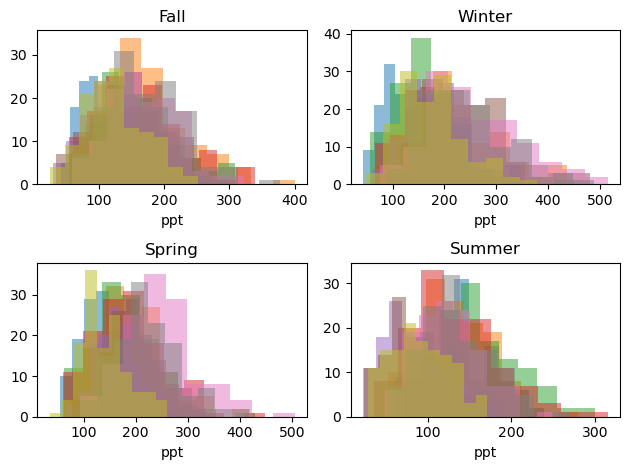

In [45]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in low_elevation_seasonal_ppt.site_no:
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==9,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==12,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==3,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==6,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [46]:
low_fallp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==9, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==9, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [47]:
low_fallp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.224055,Probably Gaussian,0.15,Null Hypothesis Accepted,NaN,NaN
09132500,0.596446,Probably Gaussian,0.17,Null Hypothesis Accepted,NaN,NaN
09147500,0.164772,Probably Gaussian,0.272,Null Hypothesis Accepted,NaN,NaN
09183500,0.055765,Probably Gaussian,0.324,Null Hypothesis Accepted,NaN,NaN
09210500,0.558768,Probably Gaussian,0.544,Null Hypothesis Accepted,NaN,NaN
09223000,0.534107,Probably Gaussian,0.553,Null Hypothesis Accepted,NaN,NaN
09239500,0.416458,Probably Gaussian,0.285,Null Hypothesis Accepted,NaN,NaN
09304500,0.978238,Probably Gaussian,0.226,Null Hypothesis Accepted,NaN,NaN
09312600,0.004901,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.375,Null Hypothesis Accepted


In [48]:
low_winterp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [49]:
low_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.285837,Probably Gaussian,0.58,Null Hypothesis Accepted,NaN,NaN
09132500,0.101126,Probably Gaussian,0.42,Null Hypothesis Accepted,NaN,NaN
09147500,0.172244,Probably Gaussian,0.714,Null Hypothesis Accepted,NaN,NaN
09183500,0.254451,Probably Gaussian,0.183,Null Hypothesis Accepted,NaN,NaN
09210500,0.159909,Probably Gaussian,0.26,Null Hypothesis Accepted,NaN,NaN
09223000,0.173651,Probably Gaussian,0.227,Null Hypothesis Accepted,NaN,NaN
09239500,0.080024,Probably Gaussian,0.238,Null Hypothesis Accepted,NaN,NaN
09304500,0.212276,Probably Gaussian,0.022,Null Hypothesis Rejected,NaN,NaN
09312600,0.104914,Probably Gaussian,0.477,Null Hypothesis Accepted,NaN,NaN


In [50]:
low_springp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    low_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    low_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [51]:
low_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09119000,0.006664,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.039,Null Hypothesis Rejected,-15.2,-20.6
09132500,0.023784,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.064,Null Hypothesis Accepted,-11.7,-24.1
09147500,0.318595,Probably Gaussian,0.033,Null Hypothesis Rejected,NaN,NaN,-14.7,-26.2
09183500,0.546723,Probably Gaussian,0.015,Null Hypothesis Rejected,NaN,NaN,-19.0,-34.7
09210500,0.748352,Probably Gaussian,0.298,Null Hypothesis Accepted,NaN,NaN,-3.8,-6.6
09223000,0.814103,Probably Gaussian,0.341,Null Hypothesis Accepted,NaN,NaN,-2.8,-6.1
09239500,0.69726,Probably Gaussian,0.087,Null Hypothesis Accepted,NaN,NaN,-9.0,-22.6
09304500,0.205011,Probably Gaussian,0.015,Null Hypothesis Rejected,NaN,NaN,-14.4,-34.5
09312600,0.227074,Probably Gaussian,0.108,Null Hypothesis Accepted,NaN,NaN,-9.7,-14.8


In [52]:
low_summerp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(1-conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        low_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value >1-conf:
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [53]:
low_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.124402,Probably Gaussian,0.981,Null Hypothesis Rejected,NaN,NaN
09132500,0.41627,Probably Gaussian,0.727,Null Hypothesis Accepted,NaN,NaN
09147500,0.615937,Probably Gaussian,0.969,Null Hypothesis Rejected,NaN,NaN
09183500,0.926014,Probably Gaussian,0.873,Null Hypothesis Accepted,NaN,NaN
09210500,0.068048,Probably Gaussian,0.998,Null Hypothesis Rejected,NaN,NaN
09223000,0.057738,Probably Gaussian,0.991,Null Hypothesis Rejected,NaN,NaN
09239500,0.69701,Probably Gaussian,0.969,Null Hypothesis Rejected,NaN,NaN
09304500,0.827898,Probably Gaussian,0.955,Null Hypothesis Rejected,NaN,NaN
09312600,0.163344,Probably Gaussian,0.898,Null Hypothesis Accepted,NaN,NaN


4. Upper Colorado River Basin

In [54]:
# Seasonal Precipitation Plot
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.month.dt.days_in_month

    # Calculate the weighted average
    return (ds).resample(month='QS-DEC').mean() * 3

In [55]:
ucrb_ppt_seasonal_mean = season_mean(p_mean.drop('WY'))
ucrb_ppt_seasonal_mean['WY'] = ucrb_ppt_seasonal_mean.month.dt.year.where(ucrb_ppt_seasonal_mean.month.dt.month<10, ucrb_ppt_seasonal_mean.month.dt.year+1)

Text(0.5, 1.0, 'Summer')

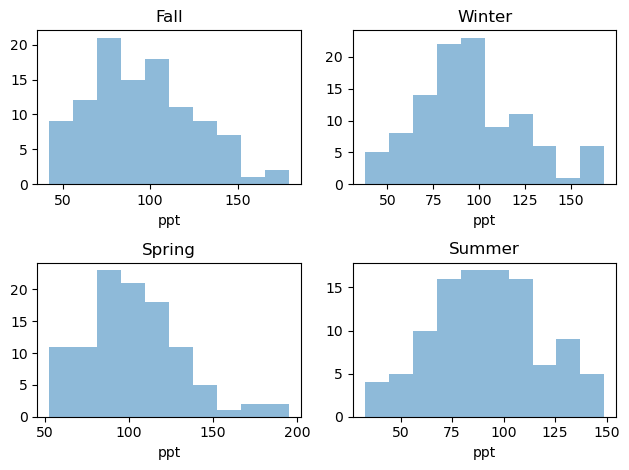

In [56]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()

ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==9),drop=True)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==12),drop=True)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==3),drop=True)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==6),drop=True)['ppt'].plot.hist(ax=axs[3], alpha=0.5)

axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

<AxesSubplot: xlabel='month'>

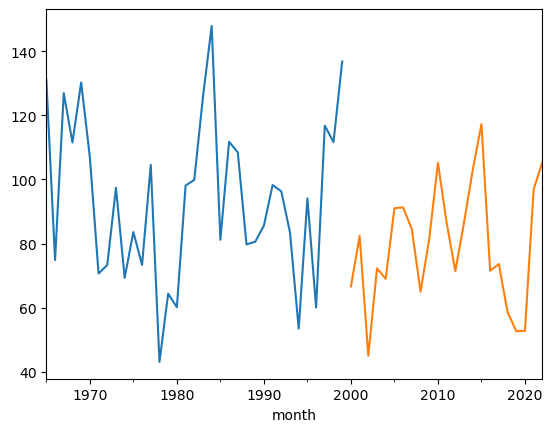

In [57]:
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==6),drop=True)['ppt'].to_pandas().loc[dt.date(test_start_year,9,30):dt.date(1999,9,30)].plot()
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==6),drop=True)['ppt'].to_pandas().loc[dt.date(1999,9,30):].plot()

In [58]:
season_list = ['fall','winter','spring','summer']
ucrb_seasonalppt_ttest_results = pd.DataFrame(index=season_list, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change (spring)',
                                                                                    'value difference (spring)'])
seasons = [ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==9),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==12),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==3),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==6),drop=True)['ppt'].to_pandas()]
for i,ds_seas in enumerate(seasons):
    single_site_pre = (ds_seas.loc[dt.date(test_start_year,9,30):dt.date(1999,9,30)])
    single_site_post = (ds_seas.loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke p'] = p

    if p > 100:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably Gaussian'
        if season_list[i] =='summer':
            # run the test for 1-conf
            z_alpha = stats.norm.ppf(conf)
        else:
            z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        if season_list[i] =='summer':
            # run the test for 1-conf
            pvalue = 1-stats.norm.cdf(z_test)
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue > 1-conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
        else:
            pvalue = stats.norm.cdf(z_test)
        
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue < conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        if season_list[i] =='summer':
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        else:
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Accepted'
    if i==2:
        # calculate the percent change between the two periods
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'percent change (spring)'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
        # calculate the difference in the mean values between the two periods
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'value difference (spring)'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [59]:
ucrb_seasonalppt_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change (spring),value difference (spring)
fall,0.363626,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.262,Null Hypothesis Accepted,NaN,NaN
winter,0.159049,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.494,Null Hypothesis Accepted,NaN,NaN
spring,0.395081,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.044,Null Hypothesis Rejected,-12.0,-12.7
summer,0.911467,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.018,Null Hypothesis Rejected,NaN,NaN


### Winter Precipitation Shift Results

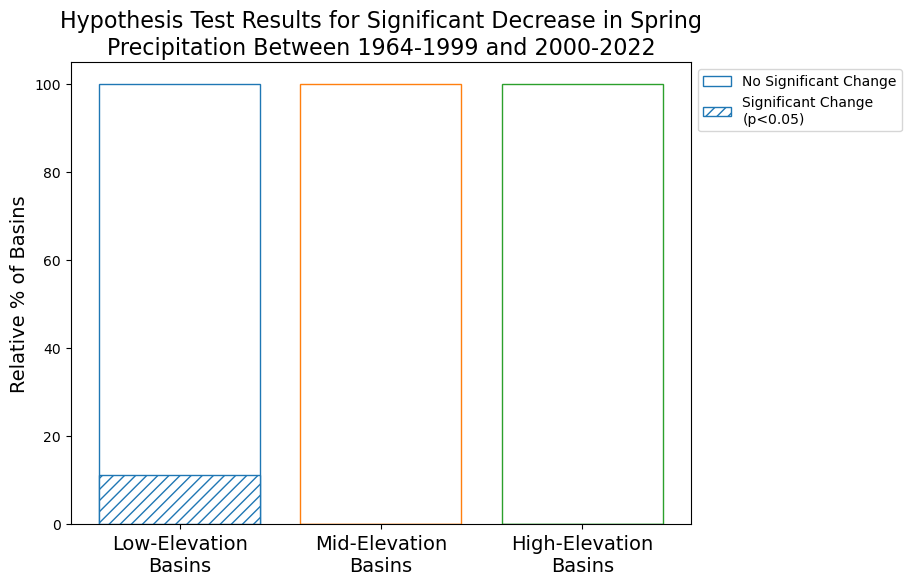

In [60]:

# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

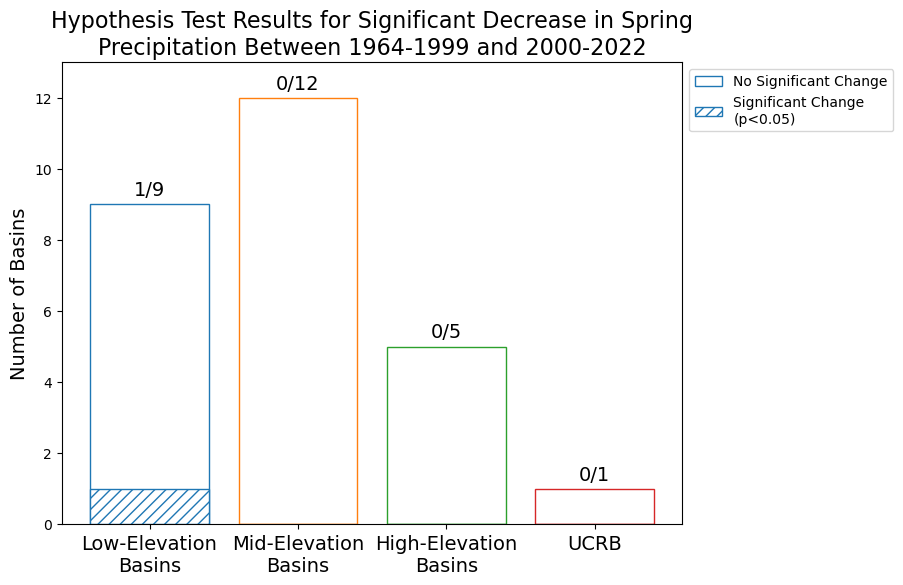

In [61]:
# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='winter']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Spring Precipitation Shift Results

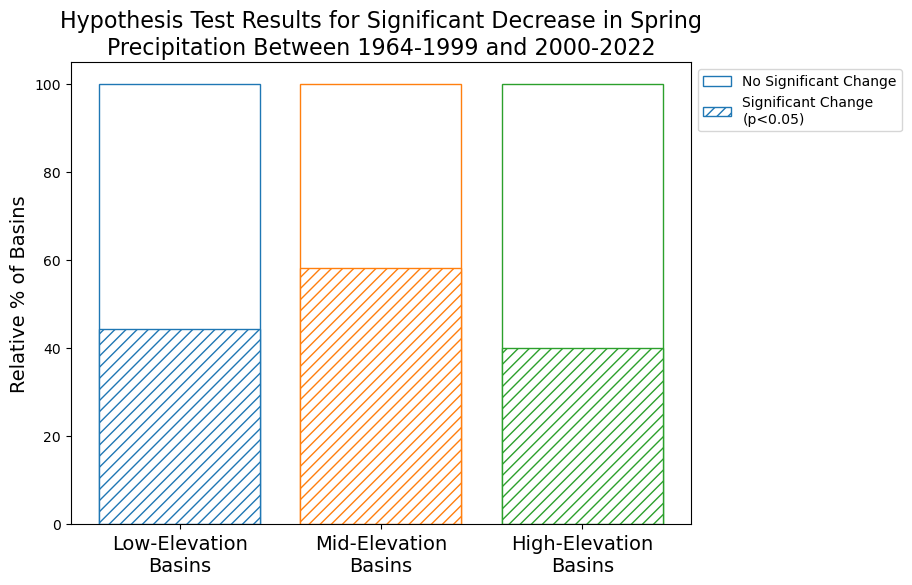

In [62]:

# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

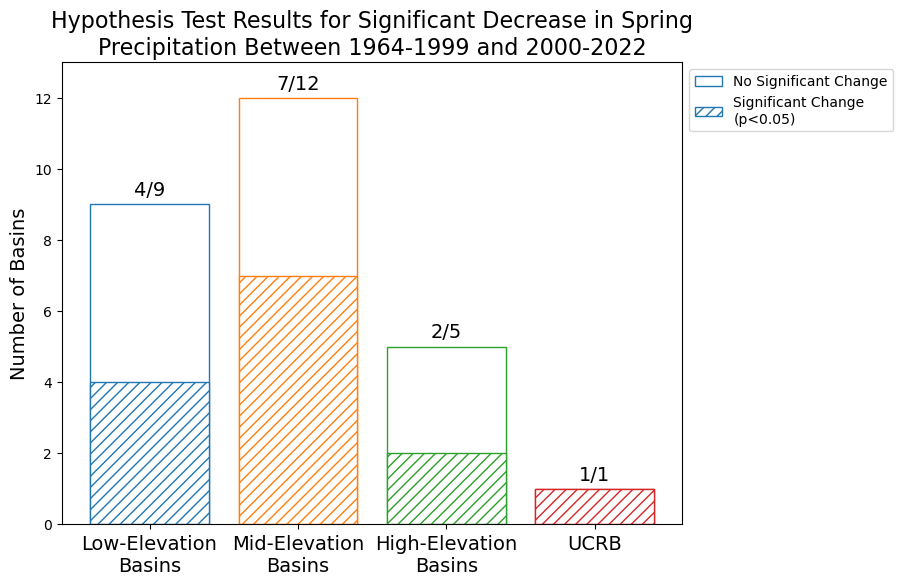

In [63]:
# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='spring']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Summer Precipitation Shift Results

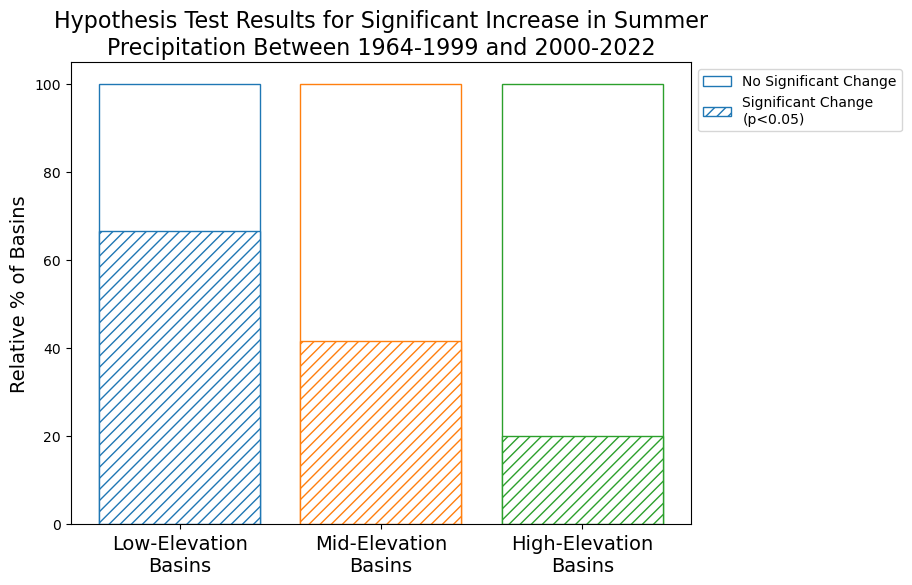

In [64]:

# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Increase in Summer\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



In [65]:
print(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)].index)
print(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)].index)
print(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)].index)

Index(['09119000', '09147500', '09210500', '09223000', '09239500', '09304500'], dtype='object')
Index(['09115500', '09124500', '09146200', '09165000', '09361500'], dtype='object')
Index(['09352900'], dtype='object')


(0.0, 13.0)

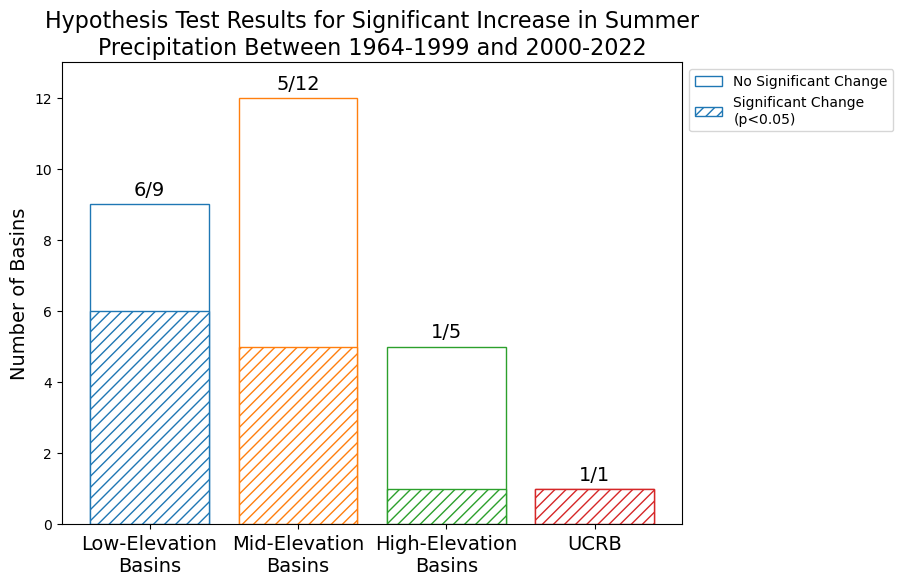

In [66]:
# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='summer']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Increase in Summer\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

In [67]:

# # scatter plot of ppt against high_elevation_annual_q q_mm
# fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(x=high_elevation_springp['ppt'].values, y=high_elevation_annual_q['q_mm'].values, alpha=0.5)
# ax.scatter(x=high_elevation_winterp['ppt'].values, y=high_elevation_annual_q['q_mm'].values, alpha=0.5)


### Look at spring P and streamflow relationship

In [42]:
hcdn_monthly_prism_precip_ds = xr.open_dataset('../data/precipdata/hcdn_monthly_prism_precip.nc')
hcdn_monthly_prism_precip_ds = hcdn_monthly_prism_precip_ds.merge(basin_group_da)
high_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==2, drop=True)
mid_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==0, drop=True)
low_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==1, drop=True)

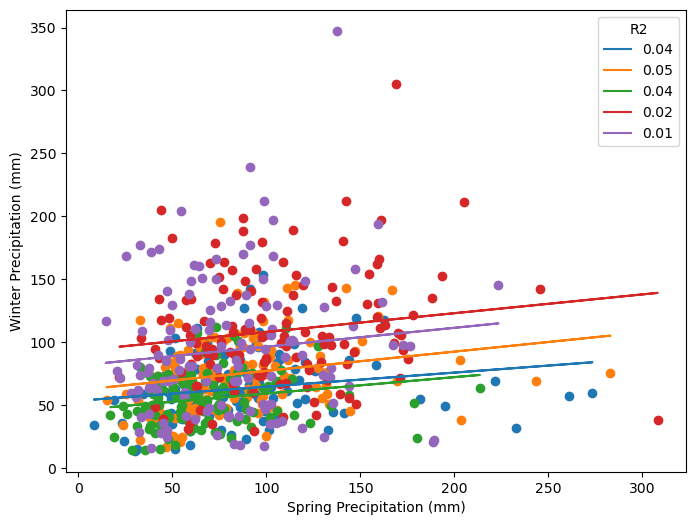

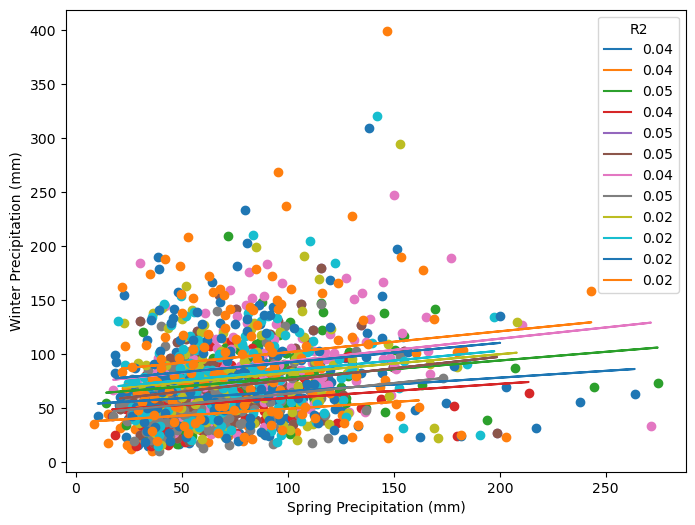

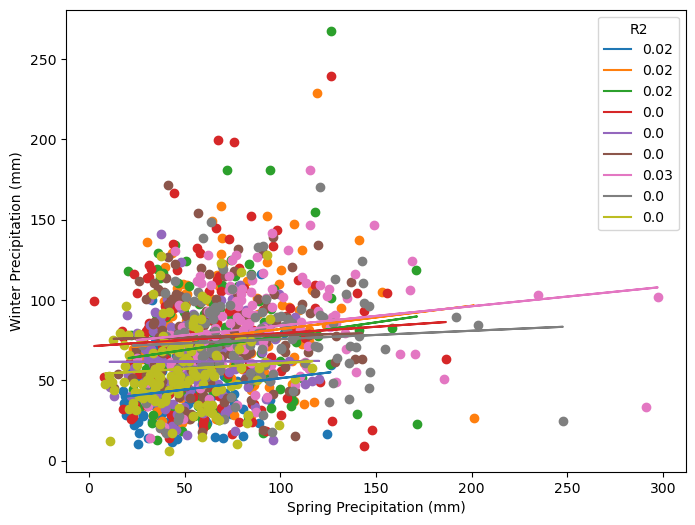

In [45]:
# plot high elevation seasonal precipitation for month = 3
# iterate through the site_no and plot the seasonal ppt vs annual q
# plot the seasonal ppt vs annual q for the site_no = 1
high_march_april_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in high_monthly_ppt.site_no:
    annualq = high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 3), drop=True).ppt.sel(site_no=site, ).values
    springp = high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 4), drop=True).ppt.sel(site_no=site, ).values
    plt.scatter(springp,
                annualq)
    # add a best fit line using linregress
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    high_march_april_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')
plt.legend(title='R2')

mid_march_april_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in mid_monthly_ppt.site_no:
    annualq = mid_monthly_ppt.where((mid_monthly_ppt['month'].dt.month == 3), drop=True).ppt.sel(site_no=site, ).values
    springp = mid_monthly_ppt.where((mid_monthly_ppt['month'].dt.month == 4), drop=True).ppt.sel(site_no=site, ).values
    plt.scatter(springp,
                annualq)
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    mid_march_april_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.legend(title='R2')
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')

# figure for low elevation basins
low_march_april_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in low_monthly_ppt.site_no:
    annualq = low_monthly_ppt.where((low_monthly_ppt['month'].dt.month == 3), drop=True).ppt.sel(site_no=site, ).values
    springp = low_monthly_ppt.where((low_monthly_ppt['month'].dt.month == 4), drop=True).ppt.sel(site_no=site, ).values
    plt.scatter(springp,
                annualq)
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    low_march_april_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')
plt.legend(title='R2')

100.17196860398951


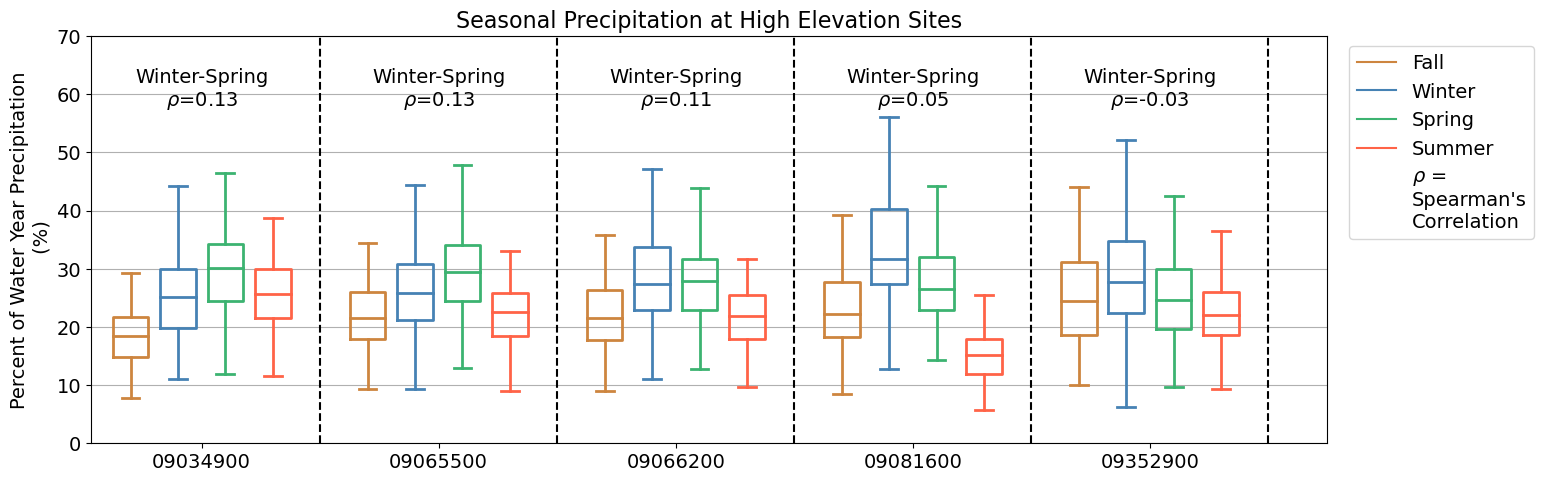

In [81]:
# create boxplot for high elevation data with a box
annual_ppt = high_elevation_annual_ppt.ppt
fall = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 9), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 12), drop=True).ppt.values.T/annual_ppt)
spring = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 3), drop=True).ppt.values.T/annual_ppt)
summer = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 6), drop=True).ppt.values.T/annual_ppt)

ticks = high_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(15,5))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
# set box colors
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+2,len(ticks))
plt.xticks(np.linspace(0,len(ticks)*2+2,len(ticks)), ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(high_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-Spring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at High Elevation Sites', size=16)
plt.ylim(0,70)


(0.0, 35.0)

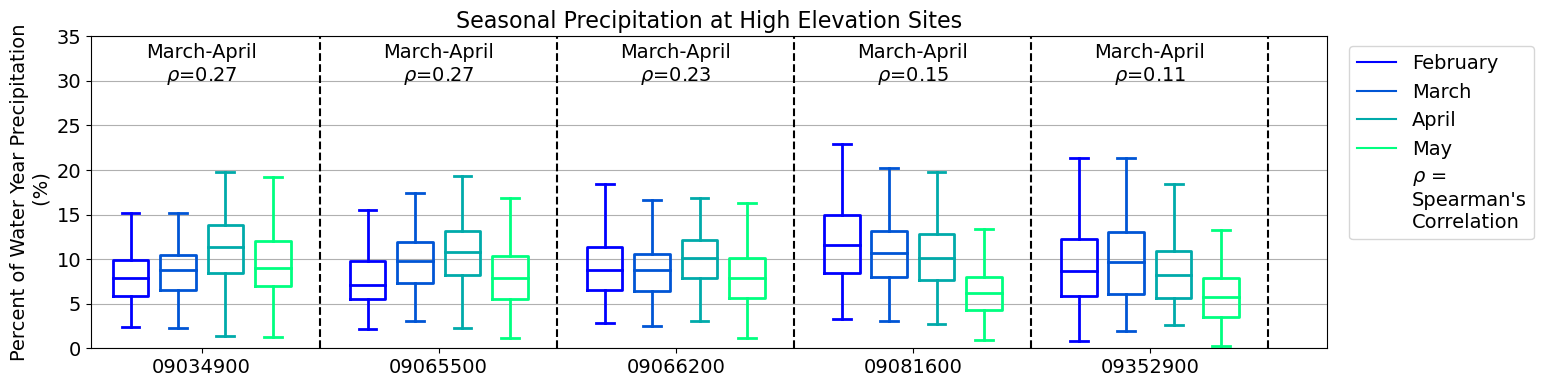

In [58]:
# import cycler
from cycler import cycler
# boxplots of precipitation by month 
# create boxplot for high elevation data with a box
annual_ppt = high_monthly_ppt.groupby('month.year').sum()['ppt']
february = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 2), drop=True).ppt.values.T/annual_ppt)
march = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 3), drop=True).ppt.values.T/annual_ppt)
april = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
may = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 5), drop=True).ppt.values.T/annual_ppt)

ticks = high_monthly_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(15,5))

february_box = plt.boxplot(february, positions=np.array(range(len(february.T)))*3.-0.9, sym='', widths=0.45,)
march_box = plt.boxplot(march, positions=np.array(range(len(march.T)))*3.-0.3, sym='', widths=0.45,)
april_box = plt.boxplot(april, positions=np.array(range(len(april.T)))*3.+0.3, sym='', widths=0.45,)
may_box = plt.boxplot(may, positions=np.array(range(len(may.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(may.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
# create a colorcycler from the winter colormap
cc = plt.cm.winter(np.linspace(0, 1,4))
# set box colors
set_box_color(february_box, cc[0]) # colors are from http://colorbrewer2.org/
set_box_color(march_box, cc[1])
set_box_color(april_box, cc[2])
set_box_color(may_box, cc[3])

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c=cc[0], label='February')
plt.plot([], c=cc[1], label='March')
plt.plot([], c=cc[2], label='April')
plt.plot([], c=cc[3], label='May')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+2,len(ticks))
plt.xticks(np.linspace(0,len(ticks)*2+2,len(ticks)), ticks, size=14)
# add the high_march_april_corr to the plot as text above each tick
for i, val in enumerate(high_march_april_corr):
    plt.text(tick_spacing[i], 30, "March-April\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at High Elevation Sites', size=16)
plt.ylim(0,35)


<xarray.DataArray 'ppt' ()>
array(21.82327458)
Coordinates:
    dim_1    <U3 'ppt' <xarray.DataArray 'ppt' ()>
array(26.37254701)
Coordinates:
    dim_1    <U3 'ppt' <xarray.DataArray 'ppt' ()>
array(27.50570586)
Coordinates:
    dim_1    <U3 'ppt' <xarray.DataArray 'ppt' ()>
array(22.43986852)
Coordinates:
    dim_1    <U3 'ppt'


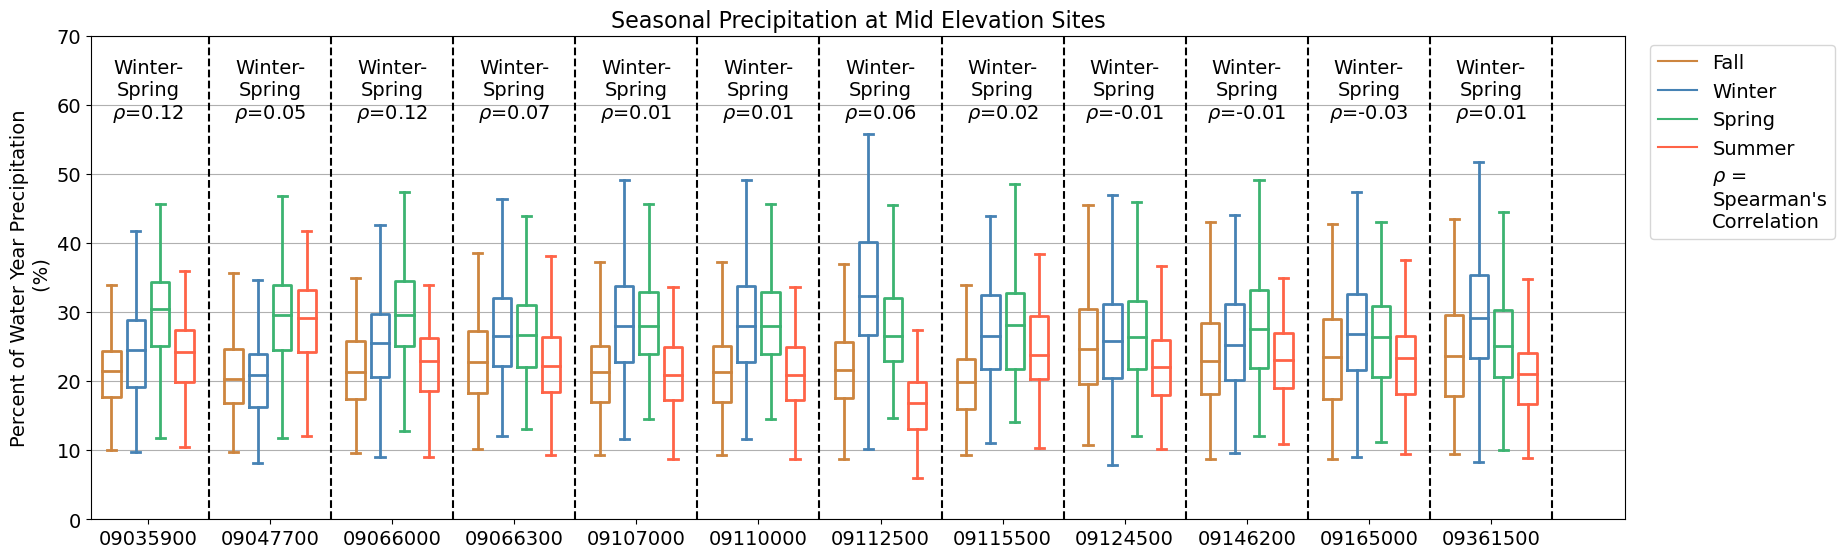

In [76]:
# create boxplot for mid elevation data with a box
annual_ppt = mid_elevation_annual_ppt.ppt
fall = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 9), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 12), drop=True).ppt.values.T/annual_ppt)
spring = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 3), drop=True).ppt.values.T/annual_ppt)
summer = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 6), drop=True).ppt.values.T/annual_ppt)

ticks = mid_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(18,6))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+9,len(ticks))
plt.xticks(tick_spacing, ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(mid_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-\nSpring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at Mid Elevation Sites', size=16)
plt.ylim(0,70)


<xarray.DataArray 'ppt' ()>
array(22.25504827)
Coordinates:
    dim_1    <U3 'ppt' <xarray.DataArray 'ppt' ()>
array(29.25685642)
Coordinates:
    dim_1    <U3 'ppt' <xarray.DataArray 'ppt' ()>
array(27.77717176)
Coordinates:
    dim_1    <U3 'ppt' <xarray.DataArray 'ppt' ()>
array(18.15032752)
Coordinates:
    dim_1    <U3 'ppt'


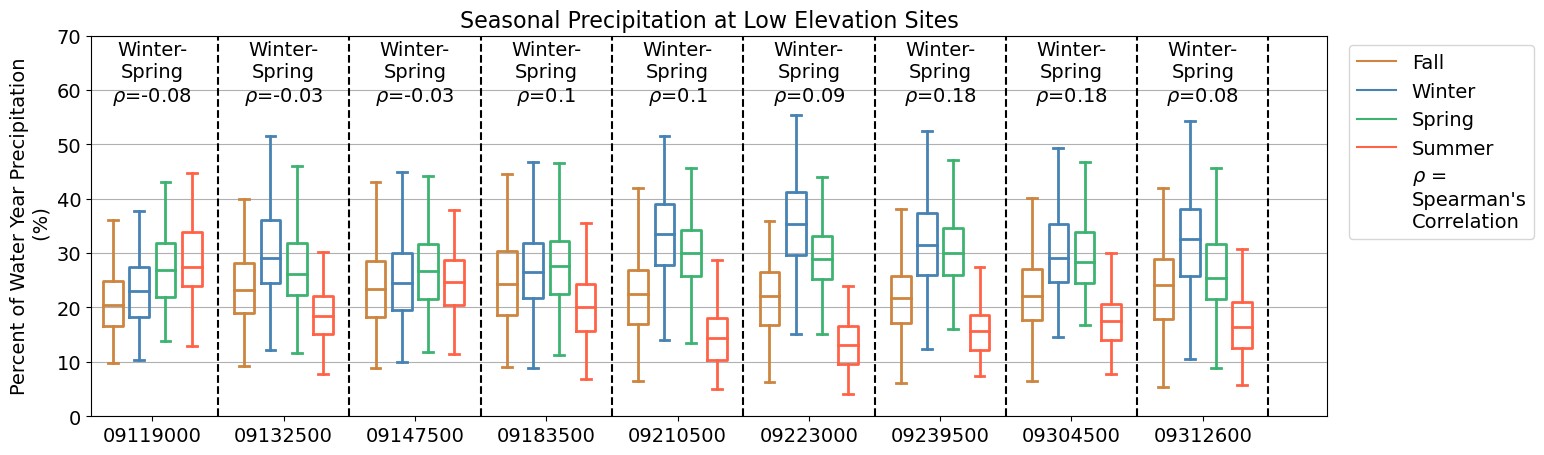

In [75]:
# create boxplot for low elevation data with a box
annual_ppt = low_elevation_annual_ppt.ppt
fall = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 9), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 12), drop=True).ppt.values.T/annual_ppt)
spring = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 3), drop=True).ppt.values.T/annual_ppt)
summer = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 6), drop=True).ppt.values.T/annual_ppt)

ticks = low_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(15,5))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+6,len(ticks))
plt.xticks(tick_spacing, ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(low_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-\nSpring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at Low Elevation Sites', size=16)
plt.ylim(0,70)



### Look at residuals in the pre-2000 and post-2000s periods

In [291]:
def spearman_dataframe(annualq_data, ppt_data):
    # create a results dataframe
    results = pd.DataFrame(columns=['pre_springp_spearman', 'pre_winterp_spearman','post_springp_spearman', 'post_winterp_spearman', 
                                    'pre_summerp_spearman', 'pre_fallp_spearman', 'post_summerp_spearman', 'post_fallp_spearman',
                                    'pre_springp_winterp_spearman', 'post_springp_winterp_spearman'], 
                           index = ppt_data.site_no.values)
    # loop through each site
    for site in annualq_data.site_no.values:
        annualq = annualq_data.q_mm.sel(site_no=site).dropna(dim='year')
        springp = ppt_data.where((ppt_data['month'].dt.month == 3) &
                                                    (ppt_data['year'].isin(annualq.year.values)), drop=True).ppt.sel(site_no=site, )
        winterp = ppt_data.where((ppt_data['month'].dt.month == 12) &
                                                    (ppt_data['year'].isin(annualq.year.values)), drop=True).ppt.sel(site_no=site, )
        summerp = ppt_data.where((ppt_data['month'].dt.month == 6) &
                                                    (ppt_data['year'].isin(annualq.year.values)), drop=True).ppt.sel(site_no=site, )
        fallp = ppt_data.where((ppt_data['month'].dt.month == 9) &
                                                    (ppt_data['year'].isin(annualq.year.values-1)), drop=True).ppt.sel(site_no=site, )
        # split annualq into pre-2000 and post-2000
        annualq_pre = annualq.where(annualq.year<2000,drop=True).values
        annualq_post = annualq.where(annualq.year>=2000,drop=True).values
        # split springp into pre-2000 and post-2000
        springp_pre = springp.where(springp.month.dt.year<2000, drop=True)
        springp_post = springp.where(springp.month.dt.year>=2000, drop=True)
        # split winterp into pre-2000 and post-2000
        winterp_pre = winterp.where(winterp.month.dt.year<1999, drop=True)
        winterp_post = winterp.where(winterp.month.dt.year>=1999, drop=True)
        # split summerp into pre-2000 and post-2000
        summerp_pre = summerp.where(summerp.month.dt.year<2000, drop=True)
        summerp_post = summerp.where(summerp.month.dt.year>=2000, drop=True)
        # split fallp into pre-2000 and post-2000
        fallp_pre = fallp.where(fallp.month.dt.year<1999, drop=True)
        fallp_post = fallp.where(fallp.month.dt.year>=1999, drop=True)
        # calculate spearmans correlation for pre-2000
        pre_springp_spearman = stats.spearmanr(annualq_pre, springp_pre)
        pre_winterp_spearman = stats.spearmanr(annualq_pre, winterp_pre)
        pre_summerp_spearman = stats.spearmanr(annualq_pre, summerp_pre)
        pre_fallp_spearman = stats.spearmanr(annualq_pre, fallp_pre)
        pre_springp_winterp_spearman = stats.spearmanr(springp_pre, winterp_pre)
        # calculate spearmans correlation for post-2000
        post_springp_spearman = stats.spearmanr(annualq_post, springp_post)
        post_winterp_spearman = stats.spearmanr(annualq_post, winterp_post)
        post_summerp_spearman = stats.spearmanr(annualq_post, summerp_post)
        post_fallp_spearman = stats.spearmanr(annualq_post, fallp_post)
        post_springp_winterp_spearman = stats.spearmanr(springp_post, winterp_post)
        # store results in spearman_df
        results.loc[site] = [pre_springp_spearman[0], pre_winterp_spearman[0], post_springp_spearman[0], post_winterp_spearman[0],
                             pre_summerp_spearman[0], pre_fallp_spearman[0], post_summerp_spearman[0], post_fallp_spearman[0],
                             pre_springp_winterp_spearman[0], post_springp_winterp_spearman[0]]
    return results

In [292]:
high_spearman = spearman_dataframe(high_elevation_annual_q,high_elevation_seasonal_ppt)
mid_spearman = spearman_dataframe(mid_elevation_annual_q,mid_elevation_seasonal_ppt)
low_spearman = spearman_dataframe(low_elevation_annual_q,low_elevation_seasonal_ppt)

In [293]:
low_spearman

,pre_springp_spearman,pre_winterp_spearman,post_springp_spearman,post_winterp_spearman,pre_summerp_spearman,pre_fallp_spearman,post_summerp_spearman,post_fallp_spearman,pre_springp_winterp_spearman,post_springp_winterp_spearman
09119000,0.501599,0.344363,0.583286,0.751553,0.140037,0.385309,0.036702,0.02428,-0.117675,0.245624
09132500,0.568646,0.471871,0.669113,0.741389,0.12673,0.397641,-0.052513,0.409373,-0.095084,0.291925
09147500,0.651217,0.229551,0.620553,0.675889,0.274003,0.437231,0.006211,0.466968,-0.013943,0.281762
09183500,0.588235,0.311765,0.582157,0.628458,0.017647,0.429412,0.145116,0.587804,-0.055882,0.259176
09210500,0.368975,0.788537,0.706381,0.618295,0.227964,0.380482,0.422925,0.434218,0.111051,0.223038
09223000,0.375463,0.787928,0.710898,0.584416,0.197734,0.398358,0.390175,0.445511,0.070421,0.159797
09239500,0.400831,0.474124,0.681536,0.699605,0.222818,0.455274,0.337098,0.325805,0.165642,0.390175
09304500,0.483698,0.416335,0.681536,0.567476,0.259546,0.414615,0.46358,0.488425,0.198613,0.31677
09312600,0.356672,0.787757,0.605872,0.835121,0.206745,0.457478,-0.28402,0.329193,0.081378,0.452287


Text(-0.02, 0.5, 'Spearman Correlation')

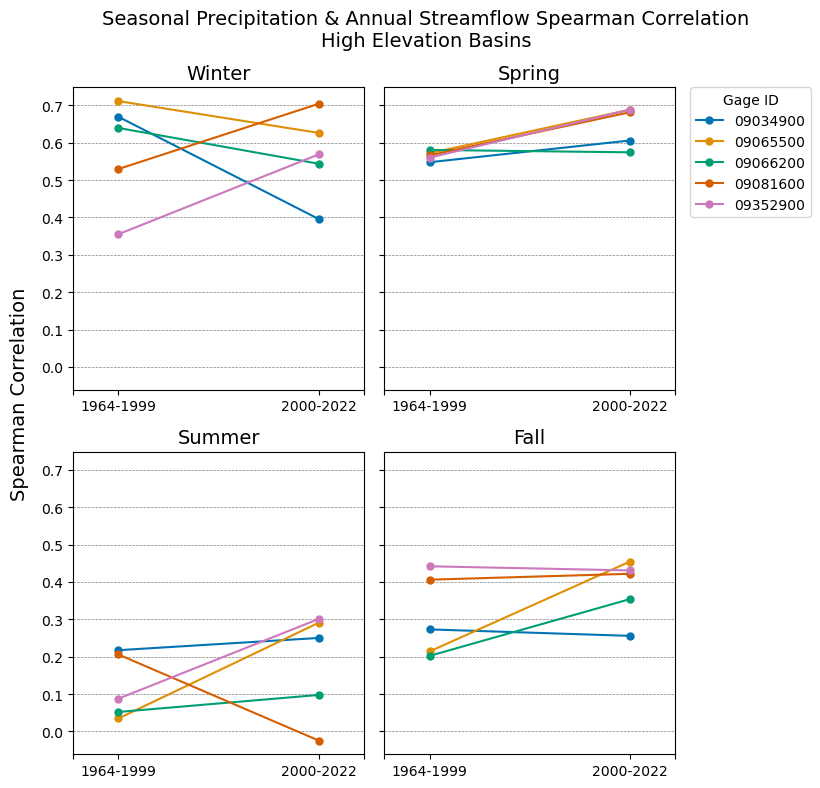

In [294]:
# create a slope chart for winter and spring periods
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True, tight_layout=True)
axs = axs.ravel()
# make a colorblind color palette with the same length as high_spearman.index
colors = sns.color_palette("colorblind", len(high_spearman.index))
# plot the winter pre and post data
for i,site in enumerate(high_spearman.index):
    temp = high_spearman.loc[site]
    axs[0].plot([2000,2022], [temp.pre_winterp_spearman, temp.post_winterp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[0].annotate(site, xy=(2022, temp.post_winterp_spearman), xytext=(2022+0.4, temp.post_winterp_spearman),ha='left', va='center', fontsize=10)
    # axs[0].annotate(site, xy=(2000, temp.pre_winterp_spearman), xytext=(2000-0.4, temp.pre_winterp_spearman),ha='right', va='center', fontsize=10)
    
# change the xlabels to be "1964-1999" and "2000-2022"
axs[0].set_xticks([1995,2000,2022,2027])
axs[0].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[0].set_title('Winter', fontsize=14)

# plot the spring pre and post data
for i,site in enumerate(high_spearman.index):
    temp = high_spearman.loc[site]
    axs[1].plot([2000,2022], [temp.pre_springp_spearman, temp.post_springp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[1].annotate(site, xy=(2000, temp.pre_springp_spearman), xytext=(2000-0.4, temp.pre_springp_spearman), fontsize=10,ha='right', va='center')
    # axs[1].annotate(site, xy=(2022, temp.post_springp_spearman), xytext=(2022+0.4, temp.post_springp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[1].set_xticks([1995,2000,2022,2027])
axs[1].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[1].set_title('Spring', fontsize=14)

# add legend outside the plot
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Gage ID')
# plot the summerp pre and post data
for i,site in enumerate(high_spearman.index):
    temp = high_spearman.loc[site]
    axs[2].plot([2000,2022], [temp.pre_summerp_spearman, temp.post_summerp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[2].annotate(site, xy=(2000, temp.pre_summerp_spearman), xytext=(2000-0.4, temp.pre_summerp_spearman), fontsize=10,ha='right', va='center')
    # axs[2].annotate(site, xy=(2022, temp.post_summerp_spearman), xytext=(2022+0.4, temp.post_summerp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[2].set_xticks([1995,2000,2022,2027])
axs[2].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[2].set_title('Summer', fontsize=14)


# plot the fallp pre and post data
for i,site in enumerate(high_spearman.index):
    temp = high_spearman.loc[site]
    axs[3].plot([2000,2022], [temp.pre_fallp_spearman, temp.post_fallp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[3].annotate(site, xy=(2000, temp.pre_fallp_spearman), xytext=(2000-0.4, temp.pre_fallp_spearman), fontsize=10,ha='right', va='center')
    # axs[3].annotate(site, xy=(2022, temp.post_fallp_spearman), xytext=(2022+0.4, temp.post_fallp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[3].set_xticks([1995,2000,2022,2027])
axs[3].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[3].set_title('Fall', fontsize=14)

fig.suptitle('Seasonal Precipitation & Annual Streamflow Spearman Correlation\nHigh Elevation Basins',size=14)
# add y-grid lines in gray to all plots
for ax in axs:
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
fig.suptitle('Seasonal Precipitation & Annual Streamflow Spearman Correlation\nHigh Elevation Basins',size=14)
# create a common Y label
fig.text(-0.02,0.5, 'Spearman Correlation', va='center', rotation='vertical', fontsize=14)

Text(-0.02, 0.5, 'Spearman Correlation')

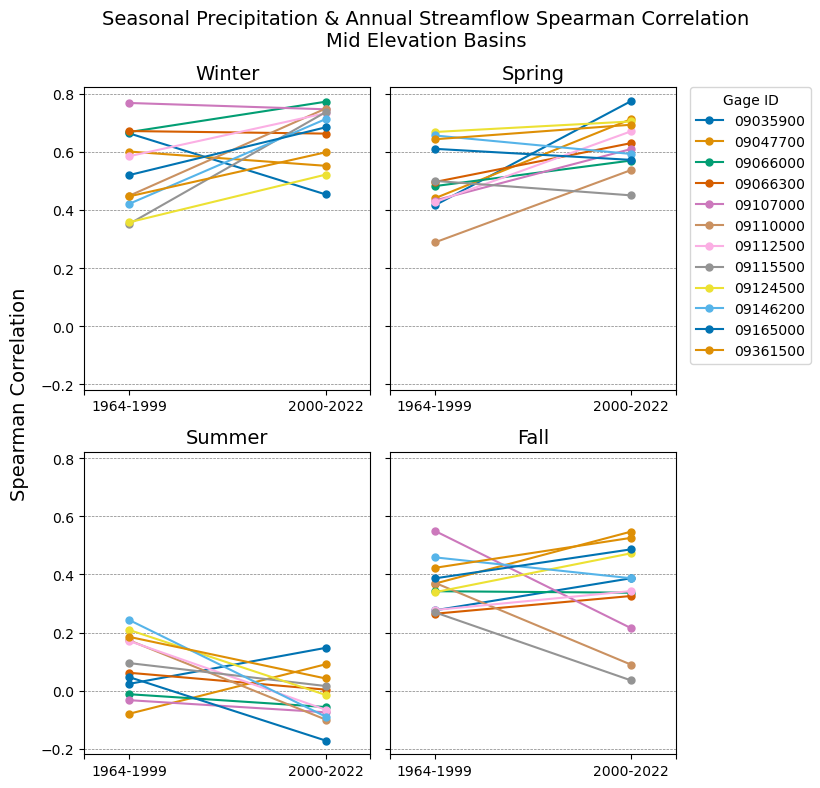

In [295]:
# create a slope chart for winter and spring periods
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True, tight_layout=True)
axs = axs.ravel()
# make a colorblind color palette with the same length as mid_spearman.index
colors = sns.color_palette("colorblind", len(mid_spearman.index))
# plot the winter pre and post data
for i,site in enumerate(mid_spearman.index):
    temp = mid_spearman.loc[site]
    axs[0].plot([2000,2022], [temp.pre_winterp_spearman, temp.post_winterp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[0].annotate(site, xy=(2022, temp.post_winterp_spearman), xytext=(2022+0.4, temp.post_winterp_spearman),ha='left', va='center', fontsize=10)
    # axs[0].annotate(site, xy=(2000, temp.pre_winterp_spearman), xytext=(2000-0.4, temp.pre_winterp_spearman),ha='right', va='center', fontsize=10)
    
# change the xlabels to be "1964-1999" and "2000-2022"
axs[0].set_xticks([1995,2000,2022,2027])
axs[0].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[0].set_title('Winter', fontsize=14)

# plot the spring pre and post data
for i,site in enumerate(mid_spearman.index):
    temp = mid_spearman.loc[site]
    axs[1].plot([2000,2022], [temp.pre_springp_spearman, temp.post_springp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[1].annotate(site, xy=(2000, temp.pre_springp_spearman), xytext=(2000-0.4, temp.pre_springp_spearman), fontsize=10,ha='right', va='center')
    # axs[1].annotate(site, xy=(2022, temp.post_springp_spearman), xytext=(2022+0.4, temp.post_springp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[1].set_xticks([1995,2000,2022,2027])
axs[1].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[1].set_title('Spring', fontsize=14)

# add legend outside the plot
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Gage ID')
# plot the summerp pre and post data
for i,site in enumerate(mid_spearman.index):
    temp = mid_spearman.loc[site]
    axs[2].plot([2000,2022], [temp.pre_summerp_spearman, temp.post_summerp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[2].annotate(site, xy=(2000, temp.pre_summerp_spearman), xytext=(2000-0.4, temp.pre_summerp_spearman), fontsize=10,ha='right', va='center')
    # axs[2].annotate(site, xy=(2022, temp.post_summerp_spearman), xytext=(2022+0.4, temp.post_summerp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[2].set_xticks([1995,2000,2022,2027])
axs[2].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[2].set_title('Summer', fontsize=14)


# plot the fallp pre and post data
for i,site in enumerate(mid_spearman.index):
    temp = mid_spearman.loc[site]
    axs[3].plot([2000,2022], [temp.pre_fallp_spearman, temp.post_fallp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[3].annotate(site, xy=(2000, temp.pre_fallp_spearman), xytext=(2000-0.4, temp.pre_fallp_spearman), fontsize=10,ha='right', va='center')
    # axs[3].annotate(site, xy=(2022, temp.post_fallp_spearman), xytext=(2022+0.4, temp.post_fallp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[3].set_xticks([1995,2000,2022,2027])
axs[3].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[3].set_title('Fall', fontsize=14)

# add y-grid lines in gray to all plots
for ax in axs:
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
fig.suptitle('Seasonal Precipitation & Annual Streamflow Spearman Correlation\nMid Elevation Basins',size=14)
# create a common Y label
fig.text(-0.02,0.5, 'Spearman Correlation', va='center', rotation='vertical', fontsize=14)


Text(-0.02, 0.5, 'Spearman Correlation')

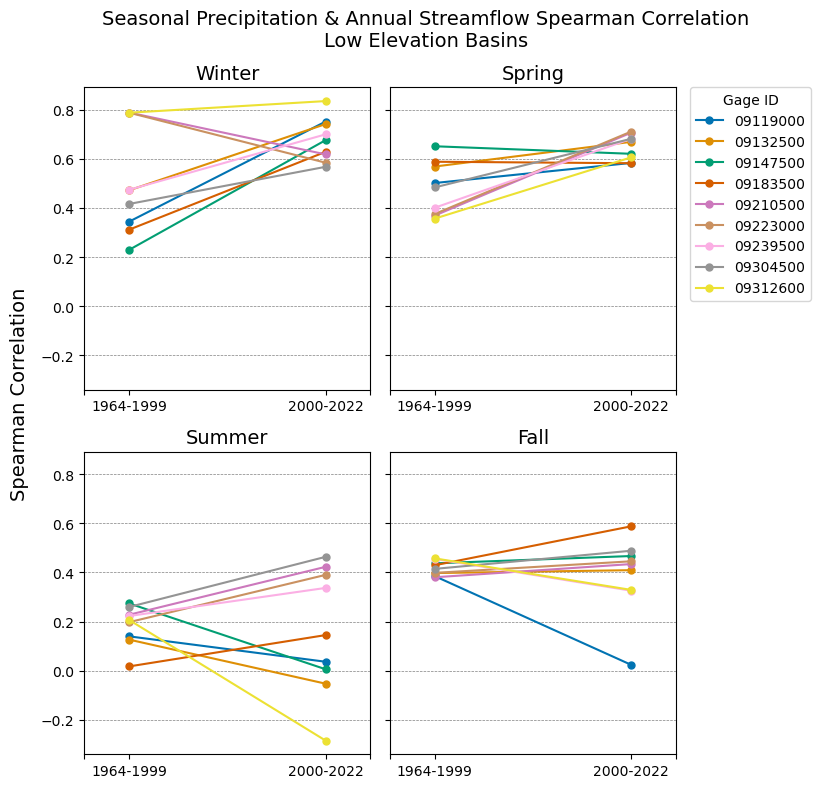

In [296]:
# create a slope chart for winter and spring periods
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True, tight_layout=True)
axs = axs.ravel()
# make a colorblind color palette with the same length as low_spearman.index
colors = sns.color_palette("colorblind", len(low_spearman.index))
# plot the winter pre and post data
for i,site in enumerate(low_spearman.index):
    temp = low_spearman.loc[site]
    axs[0].plot([2000,2022], [temp.pre_winterp_spearman, temp.post_winterp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[0].annotate(site, xy=(2022, temp.post_winterp_spearman), xytext=(2022+0.4, temp.post_winterp_spearman),ha='left', va='center', fontsize=10)
    # axs[0].annotate(site, xy=(2000, temp.pre_winterp_spearman), xytext=(2000-0.4, temp.pre_winterp_spearman),ha='right', va='center', fontsize=10)
    
# change the xlabels to be "1964-1999" and "2000-2022"
axs[0].set_xticks([1995,2000,2022,2027])
axs[0].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[0].set_title('Winter', fontsize=14)

# plot the spring pre and post data
for i,site in enumerate(low_spearman.index):
    temp = low_spearman.loc[site]
    axs[1].plot([2000,2022], [temp.pre_springp_spearman, temp.post_springp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[1].annotate(site, xy=(2000, temp.pre_springp_spearman), xytext=(2000-0.4, temp.pre_springp_spearman), fontsize=10,ha='right', va='center')
    # axs[1].annotate(site, xy=(2022, temp.post_springp_spearman), xytext=(2022+0.4, temp.post_springp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[1].set_xticks([1995,2000,2022,2027])
axs[1].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[1].set_title('Spring', fontsize=14)

# add legend outside the plot
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Gage ID')
# plot the summerp pre and post data
for i,site in enumerate(low_spearman.index):
    temp = low_spearman.loc[site]
    axs[2].plot([2000,2022], [temp.pre_summerp_spearman, temp.post_summerp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[2].annotate(site, xy=(2000, temp.pre_summerp_spearman), xytext=(2000-0.4, temp.pre_summerp_spearman), fontsize=10,ha='right', va='center')
    # axs[2].annotate(site, xy=(2022, temp.post_summerp_spearman), xytext=(2022+0.4, temp.post_summerp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[2].set_xticks([1995,2000,2022,2027])
axs[2].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[2].set_title('Summer', fontsize=14)


# plot the fallp pre and post data
for i,site in enumerate(low_spearman.index):
    temp = low_spearman.loc[site]
    axs[3].plot([2000,2022], [temp.pre_fallp_spearman, temp.post_fallp_spearman], color=colors[i], marker='o', markersize=5, label=site)
    # # add labels to the lines
    # axs[3].annotate(site, xy=(2000, temp.pre_fallp_spearman), xytext=(2000-0.4, temp.pre_fallp_spearman), fontsize=10,ha='right', va='center')
    # axs[3].annotate(site, xy=(2022, temp.post_fallp_spearman), xytext=(2022+0.4, temp.post_fallp_spearman), fontsize=10,ha='left', va='center')
# mplcursors.cursor(multiple=True).connect(
#     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# change the xlabels to be "1964-1999" and "2000-2022"
axs[3].set_xticks([1995,2000,2022,2027])
axs[3].set_xticklabels(['','1964-1999', '2000-2022',''])
# set title
axs[3].set_title('Fall', fontsize=14)

# add y-grid lines in gray to all plots
for ax in axs:
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
fig.suptitle('Seasonal Precipitation & Annual Streamflow Spearman Correlation\nLow Elevation Basins',size=14)
# create a common Y label
fig.text(-0.02,0.5, 'Spearman Correlation', va='center', rotation='vertical', fontsize=14)


### Hypothesis testing for change in the amount of annual precipitation in pre- and post-2000 periods

1) High Elevation Basins

In [297]:
high_annualp_ttest_results = pd.DataFrame(index=high_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_ppt.site_no.values:
    minyear = high_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [298]:
high_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.456461,Probably Gaussian,0.357,Null Hypothesis Accepted,NaN,NaN,-1.48,-11.39
09065500,0.752099,Probably Gaussian,0.358,Null Hypothesis Accepted,NaN,NaN,-1.63,-12.95
09066200,0.628296,Probably Gaussian,0.615,Null Hypothesis Accepted,NaN,NaN,1.22,8.76
09081600,0.447354,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN,-11.06,-113.23
09352900,0.807083,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN,-13.59,-131.33


2) Mid Elevation Basins

In [299]:
mid_annualp_ttest_results = pd.DataFrame(index=mid_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_ppt.site_no.values:
    minyear = mid_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    mid_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    mid_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [300]:
mid_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09035900,0.842069,Probably Gaussian,0.436,Null Hypothesis Accepted,NaN,NaN,-0.66,-4.76
09047700,0.089025,Probably Gaussian,0.774,Null Hypothesis Accepted,NaN,NaN,3.15,15.68
09066000,0.584751,Probably Gaussian,0.354,Null Hypothesis Accepted,NaN,NaN,-1.69,-13.53
09066300,0.402031,Probably Gaussian,0.81,Null Hypothesis Accepted,NaN,NaN,3.44,19.87
09107000,0.206468,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN,-8.15,-56.28
09110000,0.206468,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN,-8.15,-56.28
09112500,0.237267,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-13.14,-122.91
09115500,0.246166,Probably Gaussian,0.008,Null Hypothesis Rejected,NaN,NaN,-10.19,-64.73
09124500,0.722198,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN,-10.61,-81.09
09146200,0.715107,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN,-9.82,-74.5


3) Low Elevation Basins

In [301]:
low_annualp_ttest_results = pd.DataFrame(index=low_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_ppt.site_no.values:
    minyear = low_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    low_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    low_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [302]:
low_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09119000,0.607145,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-10.73,-54.78
09132500,0.264066,Probably Gaussian,0.022,Null Hypothesis Rejected,NaN,NaN,-8.38,-63.76
09147500,0.651686,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN,-9.96,-68.19
09183500,0.96931,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN,-13.19,-90.11
09210500,0.586293,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN,-9.38,-57.13
09223000,0.830156,Probably Gaussian,0.046,Null Hypothesis Rejected,NaN,NaN,-8.56,-64.0
09239500,0.916294,Probably Gaussian,0.02,Null Hypothesis Rejected,NaN,NaN,-8.87,-73.3
09304500,0.479532,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-13.91,-114.23
09312600,0.565335,Probably Gaussian,0.091,Null Hypothesis Accepted,NaN,NaN,-6.31,-35.67


4. Upper Colorado River Basin

In [303]:
ucrb_annual_ppt = ucrb_ppt_seasonal_mean.groupby('WY').sum()
ucrb_annual_ppt_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p'
                                                                                    ])
single_site_pre = np.log(ucrb_annual_ppt['ppt'].to_pandas().loc[1966:1999])
single_site_post = np.log(ucrb_annual_ppt['ppt'].to_pandas().loc[2000:])
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_annual_ppt_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [304]:
ucrb_annual_ppt_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p
UCRB,0.10518,Probably Gaussian,0.03,Null Hypothesis Rejected,NaN


Annual Precipitation Shift Plots

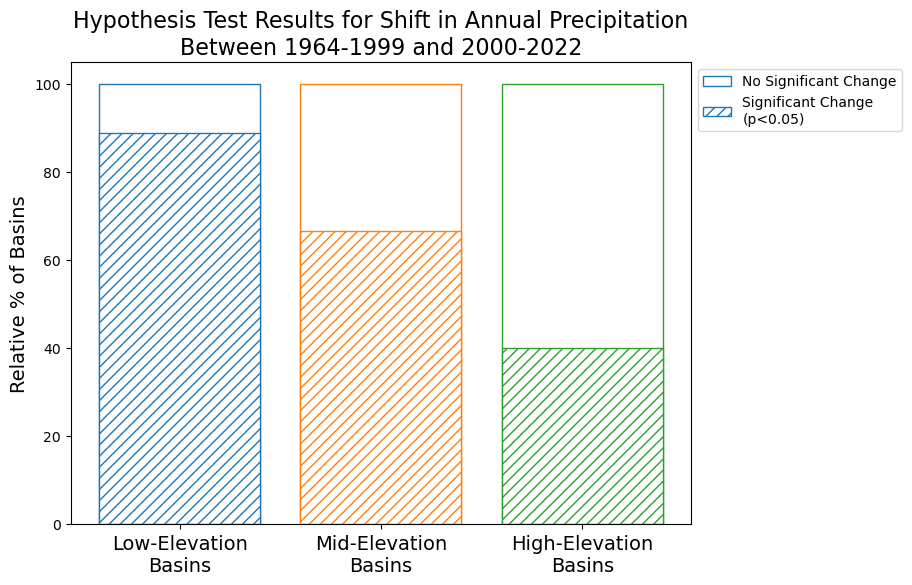

In [305]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)

(0.0, 13.0)

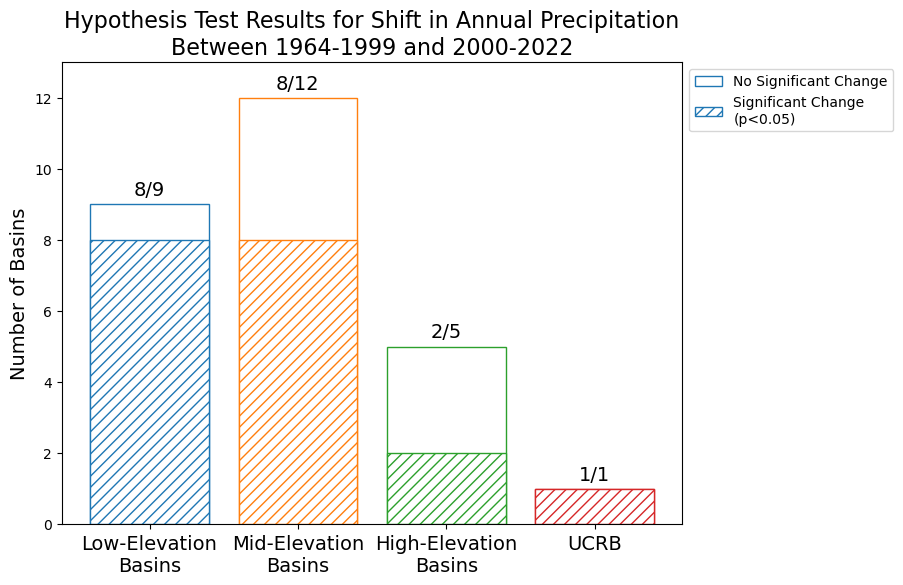

In [306]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
ucrb_rejected = len(ucrb_annual_ppt_ttest_results[(ucrb_annual_ppt_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_annual_ppt_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Percent Changes

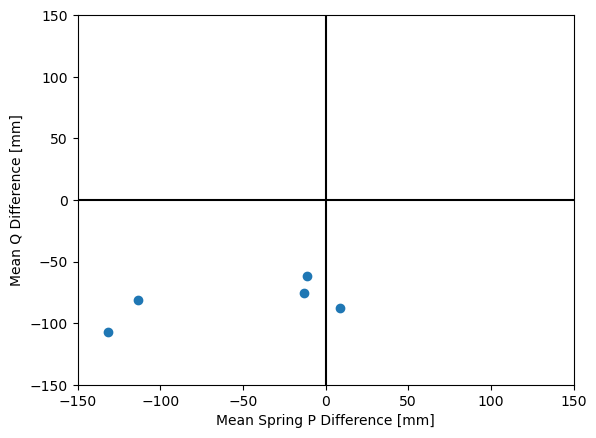

In [307]:
plt.scatter(high_annualp_ttest_results['value difference'], high_meanq_ttest_results['value difference [mm]'])
plt.ylabel('Mean Q Difference [mm]')
plt.xlabel('Mean Spring P Difference [mm]')
plt.ylim(-150,150)
plt.xlim(-150,150)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

In [308]:
high_annualp_ttest_results['value difference']/high_meanq_ttest_results['value difference [mm]']

09034900    0.184903
09065500    0.170619
09066200   -0.099659
09081600    1.389325
09352900    1.220539
dtype: object

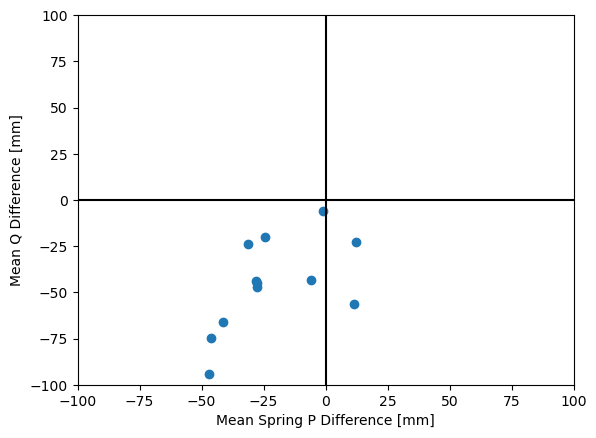

In [309]:
plt.scatter(mid_springp_ttest_results['value difference'], mid_meanq_ttest_results['value difference [mm]'])
plt.ylabel('Mean Q Difference [mm]')
plt.xlabel('Mean Spring P Difference [mm]')
plt.ylim(-100,100)
plt.xlim(-100,100)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

In [310]:
mid_springp_ttest_results['value difference']/mid_meanq_ttest_results['value difference [mm]']

09035900    0.206897
09047700   -0.530702
09066000    0.134259
09066300   -0.204626
09107000    0.583864
09110000    0.609756
09112500    0.629179
09115500    1.236181
09124500    1.322034
09146200    0.640909
09165000    0.498936
09361500     0.61631
dtype: object

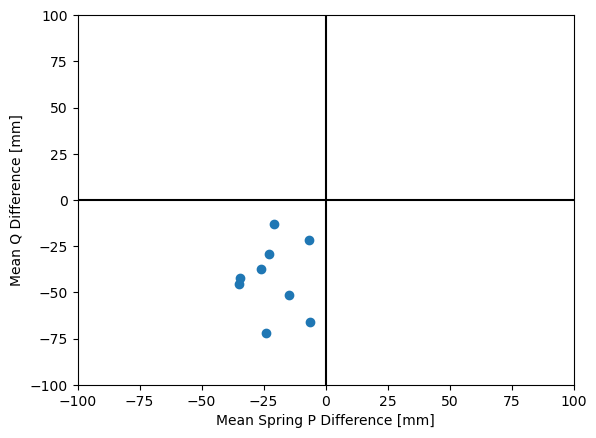

In [311]:
plt.scatter(low_springp_ttest_results['value difference'], low_meanq_ttest_results['value difference [mm]'])
plt.ylabel('Mean Q Difference [mm]')
plt.xlabel('Mean Spring P Difference [mm]')
plt.ylim(-100,100)
plt.xlim(-100,100)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

In [312]:
low_springp_ttest_results['value difference']/low_meanq_ttest_results['value difference [mm]']

09119000    1.572519
09132500    0.333795
09147500    0.696809
09183500      0.7593
09210500    0.306977
09223000    0.092705
09239500    0.771331
09304500    0.819477
09312600    0.286267
dtype: object

### Figure Mock Up

In [313]:
# get the sites in the high, mid and low meanq results that are Rejected
high_meanq_rejected = high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                  (high_meanq_ttest_results['mannwhitney p']<0.05)].index.values 
mid_meanq_rejected = mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                (mid_meanq_ttest_results['mannwhitney p']<0.05)].index.values      
low_meanq_rejected = low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                (low_meanq_ttest_results['mannwhitney p']<0.05)].index.values  
# combine these into a single array
all_meanq_rejected = np.concatenate((high_meanq_rejected, mid_meanq_rejected, low_meanq_rejected))     

# get the sites in the high, mid and low meanq results with t-test p-values >0.05 and less than 0.10
high_meanq_ttest_p10 = high_meanq_ttest_results[((high_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['t-test p']<=0.10)) |
                                                   ((high_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['mannwhitney p']<=0.10)) ].index.values
mid_meanq_ttest_p10 = mid_meanq_ttest_results[((mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['t-test p']<=0.10)) |
                                                    ((mid_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['mannwhitney p']<=
                                                     0.10)) ].index.values
low_meanq_ttest_p10 = low_meanq_ttest_results[((low_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['t-test p']<=0.10)) |
                                                    ((low_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['mannwhitney p']<=0.10)) ].index.values
# combine these into a single array
all_meanq_ttest_p10 = np.concatenate((high_meanq_ttest_p10, mid_meanq_ttest_p10, low_meanq_ttest_p10))

# get the sites in the high, mid and low meanq results with t-test p-values >0.05 and less than 0.10
high_meanq_ttest_acc = high_meanq_ttest_results[((high_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['t-test p']>0.10)) |
                                                   ((high_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['mannwhitney p']>0.10)) ].index.values
mid_meanq_ttest_acc = mid_meanq_ttest_results[((mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['t-test p']>0.10)) |
                                                    ((mid_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['mannwhitney p']>0.10)) ].index.values
low_meanq_ttest_acc = low_meanq_ttest_results[((low_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['t-test p']>0.10)) |
                                                    ((low_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['mannwhitney p']>0.10)) ].index.values
# combine these into a single array
all_meanq_ttest_acc = np.concatenate((high_meanq_ttest_acc, mid_meanq_ttest_acc, low_meanq_ttest_acc))

In [314]:
# get the sites in the high, mid, and low meanq percent change
high_meanq_percentchange = high_meanq_ttest_results['percent change']
mid_meanq_percentchange = mid_meanq_ttest_results['percent change']
low_meanq_percentchange = low_meanq_ttest_results['percent change']
# combine these into a single series
all_meanq_percentchange = pd.concat([high_meanq_percentchange, mid_meanq_percentchange, low_meanq_percentchange])

# get the sites in the high, mid and low springp results that are percent change
high_springp_percentchange = high_springp_ttest_results['percent change']
mid_springp_percentchange = mid_springp_ttest_results['percent change']
low_springp_percentchange = low_springp_ttest_results['percent change']
# combine these into a single series
all_springp_percentchange = pd.concat([high_springp_percentchange, mid_springp_percentchange, low_springp_percentchange])

# pull in the PRISM percent diff 
prism_springp_diff = xr.open_dataset('../data/precipdata/springP_prism_percentdiff.nc')

/tmp/ipykernel_26945/501415518.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


(-146884.13108946453, 444992.35517272865, 3941210.004222732, 4825078.890374275)

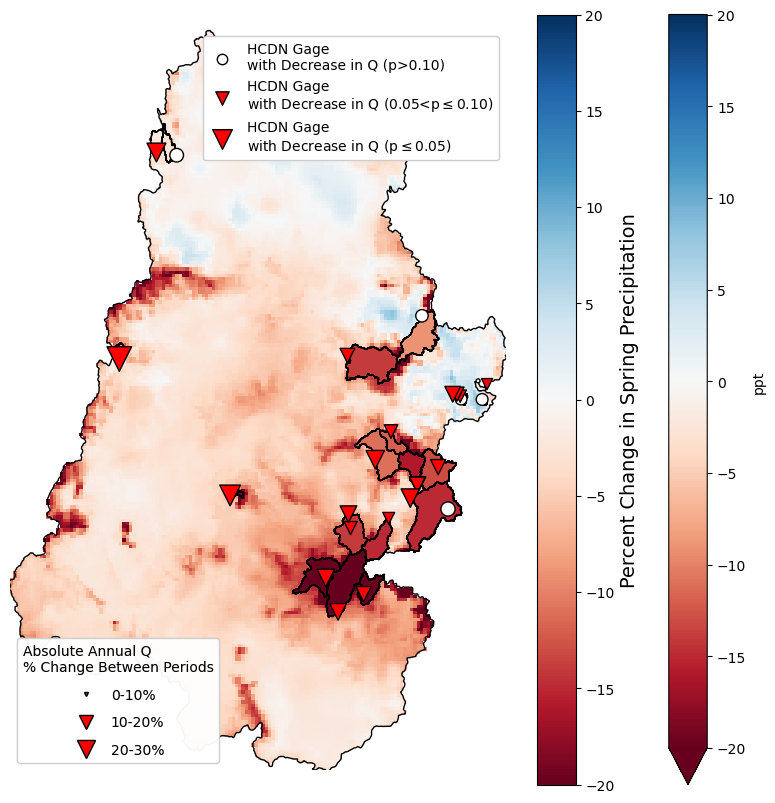

In [315]:
# import gage locations
gage_locations = gpd.read_file('../data/geodata/ucrb_hcdn_merged_gages.geojson')
# import hcdn basins
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
# filter basins in hcdn_daily_q
hcdn_basins = hcdn_basins[hcdn_basins['gage'].isin(hcdn_daily_q.site_no.values)]
hcdn_basins = hcdn_basins.set_crs('EPSG:32613', allow_override=True)
# set index col to be 'gage' column
hcdn_basins = hcdn_basins.set_index('gage')
# import the UCRB basin boundary
ucrb_basin = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
# set the crs to the same as hcdn basins
gage_locations = gage_locations.to_crs(hcdn_basins.crs)
ucrb_basin = ucrb_basin.to_crs(hcdn_basins.crs)


# add 0 to the beginning of the site_no to match the format in the hcdn_daily_q dataframe
gage_locations['STAID'] = '0' + gage_locations['STAID'].astype(str)
# filter out the gages not included in the analysis
gage_locations = gage_locations[gage_locations['STAID'].isin(hcdn_daily_q.site_no.values)]
# reset index
gage_locations = gage_locations.set_index('STAID')
# add all_meanq_percentchange as a column in the gage_locations dataframe
gage_locations['meanq_percentchange'] = np.abs(all_meanq_percentchange.astype(int))*8

# add all_springp_percentchange as a column in the hcdn_basins dataframe
hcdn_basins['springp_percentchange'] = (all_springp_percentchange.astype(int))

# create a fig and ax
fig, ax = plt.subplots(figsize=(10,10))

# plot the prism percent diff
prism_springp_diff['ppt'].plot(ax=ax,
                        cmap='RdBu',
                        vmin=-20,
                        vmax=20,
                        )
                     
# plot the hcdn basins
hcdn_basins.plot(ax=ax, 
                 column='springp_percentchange',
                 cmap='RdBu', 
                 edgecolor='black', 
                 linewidth=1,
                 vmin=-20, 
                 vmax=20)
# plot a legend for the colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-20, vmax=20))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('Percent Change in Spring Precipitation', fontsize=14)
# plot the ucrb basins
ucrb_basin.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# plot the gage location geometry with sizes based on all_meanq_percentchange
gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)].plot(markersize=gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)]['meanq_percentchange'], 
                    label='HCDN Gage\nwith Decrease in Q (p>0.10)', 
                    marker='o', 
                    ax=ax, 
                    color='white', 
                    ec='k')
# plot gage locations with significant change in meanq                    
gage_locations.loc[all_meanq_ttest_p10].plot(markersize=gage_locations.loc[all_meanq_ttest_p10]['meanq_percentchange'],
                                            label='HCDN Gage\nwith Decrease in Q (0.05<p$\leq$0.10)', 
                                            marker='v', 
                                            ax=ax, 
                                            color='red', 
                                            ec='k')
# plot gage locations with significant change in meanq                    
gage_locations.loc[all_meanq_rejected].plot(markersize=gage_locations.loc[all_meanq_rejected]['meanq_percentchange'],
                                            label='HCDN Gage\nwith Decrease in Q (p$\leq$0.05)', 
                                            marker='v', 
                                            ax=ax, 
                                            color='red', 
                                            ec='k')
# create a legend for the gage locations
# need to add existing legend back

leg1 = ax.legend(loc='upper right',framealpha=1)
# create a second legend for the size of the gage locations
# some bins to indicate size in legend
_, bins = pd.cut(gage_locations['meanq_percentchange']/8, bins=[1,11,21], precision=0, retbins=True)
# create second legend
import matplotlib.lines as mlines
# create label for each bin with a range between the bin values
labels = [str(int(b-1))+'-'+str(int(bins[i]-1+10))+'%' for i, b in enumerate(bins)]
# labels.append(str(int(bins[-1]))+'%+')
ax.add_artist(
    ax.legend(
        handles=[
            mlines.Line2D(
                [],
                [],
                color="red",
                lw=0,
                marker="v",
                markeredgecolor='k',
                markersize=np.sqrt(b*8),
                label=labels[i],
            )
            for i, b in enumerate(bins)
        ],
        loc='lower left',
        # make distance between legend items a bit bigger
        labelspacing=1,
        # add title to the legend
        title='Absolute Annual Q\n% Change Between Periods',
    )
)
# restore original legend
ax.add_artist(leg1)
# remove axis labels
ax.axis('off')

### ANOVA testing for differences between basins in pre- and post-2000 streamflow

In [79]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
dates = [date2DOWY(x) for x in hcdn_daily_q.date.values]
dowy_da = pd.Series(dates,index=hcdn_daily_q.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_ds = hcdn_daily_q.copy()
hcdn_q_dowy_ds = hcdn_q_dowy_ds.merge(dowy_da)
hcdn_q_dowy_spsu_ds = hcdn_q_dowy_ds.where(hcdn_q_dowy_ds.date.dt.month.isin([3,4,5,6,7,8,9,10]), drop=True)

In [80]:
hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY<2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_pre2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_pre2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_pre2000_ds.merge(dowy_da)

In [81]:
hcdn_q_dowy_post2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY>=2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_post2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_post2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_post2000_ds = hcdn_q_dowy_post2000_ds.merge(dowy_da)

In [82]:
hcdn_q_dowy_mean = hcdn_q_dowy_spsu_ds.groupby('dowy').mean()
hcdn_q_dowy_pre2000_mean = hcdn_q_dowy_pre2000_ds.groupby('dowy').mean()
hcdn_q_dowy_post2000_mean = hcdn_q_dowy_post2000_ds.groupby('dowy').mean()

6.378322826263686
0.0017934681352298782


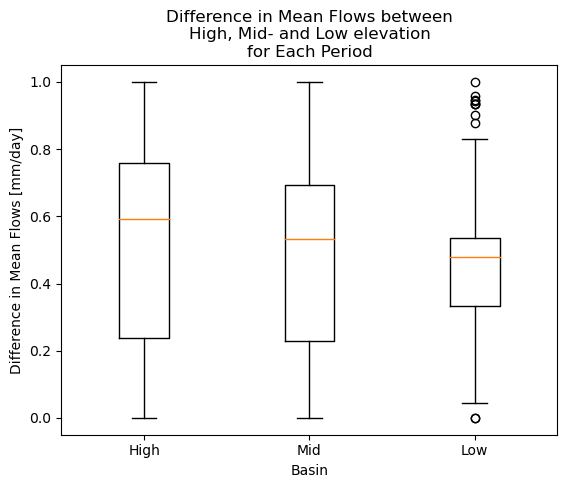

In [78]:
site_diff_high = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_mid = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_low = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']))
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))
print(fvalue)
print(pvalue)
# Using boxplot, we can start to visually see differences between the periods
plt.boxplot([((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))],
           labels=['High', 'Mid', 'Low'])

# Add labels
plt.xlabel('Basin')
plt.ylabel('Difference in Mean Flows [mm/day]')
plt.title('Difference in Mean Flows between\nHigh, Mid- and Low elevation\nfor Each Period');

Prior to running our test, lets test to make sure our data is valid for using this test

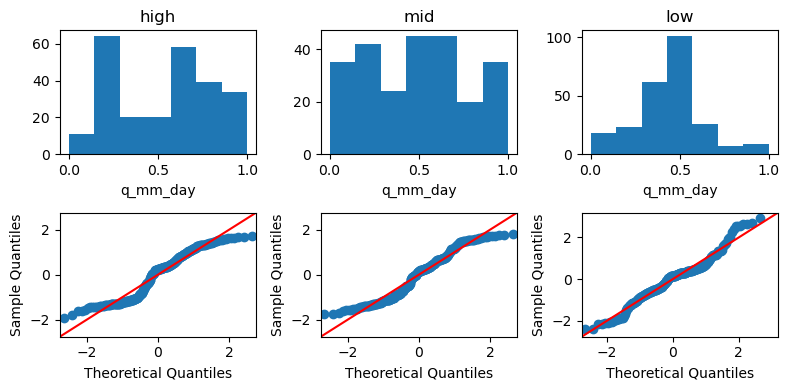

In [79]:
# test for normality 
fig, axs = plt.subplots(ncols=3, nrows=2, tight_layout=True, figsize=(8,4))
val_list = [((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))]
val_title =['high', 'mid', 'low']
for i, val in enumerate(val_list):
    val.plot.hist(ax=axs[0,i], bins=7)
    axs[0,i].set_title(val_title[i])

    sm.qqplot((val-val.mean())/val.std(), line ='45', ax=axs[1,i]);


Fails the Bartlett test which tests for equal variance

In [80]:
stats.bartlett(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min()))),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))

<xarray.DataArray 'q_mm_day' (dowy: 246)>
array([5.74392642e-01, 6.10382086e-01, 5.32735608e-01, 5.48752500e-01,
       5.52848543e-01, 6.49761675e-01, 6.25743972e-01, 5.48043096e-01,
       5.42409552e-01, 5.55183914e-01, 5.38633840e-01, 5.12146445e-01,
       4.53781281e-01, 5.04695064e-01, 5.19257414e-01, 4.93173381e-01,
       5.21223085e-01, 5.00570658e-01, 4.77851782e-01, 5.08511567e-01,
       5.05160446e-01, 5.27233602e-01, 5.43152687e-01, 5.24693671e-01,
       5.54807201e-01, 5.56958273e-01, 4.55596803e-01, 5.01233233e-01,
       5.21936585e-01, 5.00693131e-01, 4.81098891e-01, 4.05564235e-01,
       4.63092784e-01, 4.75336861e-01, 4.89353588e-01, 4.88633406e-01,
       5.05853234e-01, 5.22440682e-01, 5.40848085e-01, 4.99150947e-01,
       5.00686326e-01, 5.18026746e-01, 5.74013440e-01, 6.67911612e-01,
       7.07211054e-01, 7.58491080e-01, 7.72177569e-01, 8.25277054e-01,
       8.76951468e-01, 9.34015440e-01, 9.33494270e-01, 9.44681241e-01,
       9.57182681e-01, 1.00000000e+00, 9.44892337e-01, 9.33581598e-01,
       9.02807025e-01, 8.30691566e-01, 8.11327901e-01, 7.69230691e-01,
       7.47066173e-01, 7.07741794e-01, 6.67326626e-01, 7.09955887e-01,
       7.04207275e-01, 6.32396148e-01, 6.07009574e-01, 6.23192068e-01,
       5.82116227e-01, 6.59391986e-01, 6.66665810e-01, 7.00052562e-01,
       6.75871958e-01, 6.47451194e-01, 6.63145113e-01, 6.76602917e-01,
       6.69313293e-01, 6.04372200e-01, 5.54778243e-01, 5.20564392e-01,
...
       3.10778287e-01, 3.21526349e-01, 3.31106695e-01, 3.28851284e-01,
       3.34987504e-01, 3.24783743e-01, 3.42935157e-01, 3.29005915e-01,
       3.47080171e-01, 3.81237676e-01, 4.32553549e-01, 3.87985222e-01,
       3.91438908e-01, 3.99389645e-01, 4.29811072e-01, 4.15404634e-01,
       4.20271092e-01, 4.69481501e-01, 4.81375513e-01, 5.83598832e-01,
       5.22846711e-01, 5.33514348e-01, 5.06003862e-01, 4.85119262e-01,
       5.66076414e-01, 5.32847871e-01, 5.30654413e-01, 4.90580629e-01,
       5.01359947e-01, 5.01506294e-01, 5.36731121e-01, 5.22691326e-01,
       5.24561818e-01, 4.77840234e-01, 4.89033695e-01, 5.89798460e-01,
       4.79447273e-01, 4.79155145e-01, 5.06381031e-01, 4.97886945e-01,
       4.86847737e-01, 5.10283972e-01, 5.42391176e-01, 4.80960321e-01,
       5.16693974e-01, 4.72724473e-01, 4.93211119e-01, 5.10129474e-01,
       5.07604679e-01, 5.06619341e-01, 4.70805619e-01, 5.02367330e-01,
       4.41130469e-01, 3.99521486e-01, 4.34111647e-01, 5.25200369e-01,
       5.60686913e-01, 4.91002666e-01, 4.03094146e-01, 3.49517431e-01,
       3.55696355e-01, 4.58325322e-01, 4.14460135e-01, 4.33264388e-01,
       3.30133639e-01, 3.48490890e-01, 3.06206525e-01, 2.82726773e-01,
       3.66936479e-01, 4.80386079e-01, 4.03298033e-01, 3.61203825e-01,
       3.53705621e-01, 3.66870765e-01, 4.84293811e-01, 4.79282562e-01,
       4.47758002e-01, 3.11576919e-01])
Coordinates:
  * dowy     (dowy) float64 0.0 1.0 2.0 3.0 4.0 ... 362.0 363.0 364.0 365.0

In [81]:
site_diff_high['elevation_cluster'] = 'high'
site_diff_mid['elevation_cluster'] = 'mid'
site_diff_low['elevation_cluster'] = 'low'

In [82]:
df_reshaped = pd.concat([site_diff_high.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         site_diff_mid.to_dataframe()[['elevation_cluster','q_mm_day']],
                         site_diff_low.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         ]).reset_index()
# perform multiple pairwise comparison (Tukey HSD), 
# endog is response variable, groups are the tested groups to compare
period_comp = pairwise_tukeyhsd(endog=df_reshaped['q_mm_day'], groups=df_reshaped['elevation_cluster'], alpha=0.05)

# display the results table
print(period_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low  -0.0724 0.0001 -0.1117 -0.033   True
  high    mid  -0.0233 0.3468 -0.0626 0.0161  False
   low    mid   0.0491 0.0098  0.0097 0.0884   True
---------------------------------------------------


The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

In [83]:
stats.kruskal(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))

KruskalResult(statistic=13.579860214429296, pvalue=0.0011250474041236997)